# Quickstart: オフ方策評価とオフ方策選択 (連続行動空間, 発展的内容)
このノートブックでは 入札オークション (Real-Time Bidding; RTB) の人工データセット上で **オフ方策学習(OPE)とオフ方策選択(OPS)** のより発展的な内容やその活用例を紹介します．

特に、以下の3つの順番で解説していきます: 
1. セットアップ，人工データの生成とオフライン強化学習
2. 様々なオフ方策評価 (方策価値推定，累積分布関数推定)
3. オフ方策選択

このライブラリは，オンラインとオフラインの方策学習およびモデルベースのオフ方策評価の一部で [d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを利用しています．
また、実装のワークフローは[Open Bandit Pipeline](https://github.com/st-tech/zr-obp)を参考にしています．

In [2]:
# SCOPE-RL モジュールのインポート
import scope_rl
from rtbgym import RTBEnv, CustomizedRTBEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead, ContinuousEvalHead
from scope_rl.policy import TruncatedGaussianHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# d3rlpy アルゴリズムのインポート
from d3rlpy.algos import RandomPolicy
from d3rlpy.preprocessing import MinMaxObservationScaler, MinMaxActionScaler

# その他のライブラリのインポート
import gym
import torch

In [3]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# バージョン
print(scope_rl.__version__)

0.1.2


In [5]:
# random stateの設定
random_state = 12345

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [7]:
# logディレクトリ
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [8]:
# warnings
import warnings
warnings.simplefilter('ignore')

## 1. セットアップ，人工データ生成，オフライン強化学習
まず初めに，今回用いるRTB環境を紹介します．

#### 強化学習でのRTB環境のセットアップ
RTBにおいて強化学習エージェントの目的は，予算制約が与えられもとで，一つのエピソード内でのKPI(クリックやコンバージョン)を最大化することです. KPIを最大にするために，エージェントは入札価格関数パラメータ $\alpha$ を選択します．
入札価格関数パラメータ $\alpha$ を利用することで以下の入札価格を決定します．\
$bid_{t，i} = \alpha \cdot r^{\ast}$，
ここで$r^{\ast}$はKPIの予測値または期待値を表します.

この問題を制約付きマルコフ決定過程(CMDP)として定式化します.

- `タイムステップ`: 一つのエピソード(一日，一週間)に含まれるタイムステップ(24時間，数日など).
- `状態`: それぞれのタイムステップで，環境からフィードバックが返ってきます.
  - タイムステップ
  - 残予算
  - 一つ前のタイムステップでのインプレッション単位の特徴(予算消費率，一つのインプレッションあたりのコスト，オークション落札率，報酬)
  - 一つ前のタイムステップでの入札関数パラメータ(強化学習エージェントが選ぶ行動) 
- `行動`: エージェントはKPIを最大化するために入札価格パラメータ$\alpha$を選択します.
- `報酬`: 一つのタイムステップあたりに得られたクリックまたはコンバージョンの合計数.
- `制約`: あらかじめ決められた、一つのエピソードあたりの予算．

より詳細に環境の引数を確認したい場合は，次のノートブックを参照してください．[examples/quickstart_ja/rtb/rtb_synthetic_customize_env_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_customize_env_ja.ipynb).


In [9]:
# SCOPE-RLで実装されている連続行動空間に対する標準的な環境
env = gym.make("RTBEnv-continuous-v0")

#### 人工データの生成
次にデータ収集方策$\pi_0$からデータを集めます：
$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

ここで $s_t \in \mathcal{S}$ は時刻$t$で観測された状態，$a_t$ はデータ収集方策 $\pi_0$によって選択された行動，$r_t$は状態と行動に応じて観測された報酬を表します．

`SyntheticDataset` は以下の引数を持っています:
- `env`: 前のセクションで紹介したRTB環境を定義.
- `state_keys`: 状態変数の名前.
- `max_episode_steps`: 一つのエピソードにおける連続意思決定の数（上限）.

より詳細にデータ収集と可視化について知りたい場合は，以下を参照してください．[examples/quickstart_ja/rtb/rtb_synthetic_data_collection_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_data_collection_ja.ipynb).

In [10]:
# データ収集方策
from d3rlpy.algos import SACConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer

# モデル
sac = SACConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,   # 0.1
        maximum=env.action_space.high,  # 10
    ),
).create(device=device)

# 再生バッファの設定
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)

In [ ]:
# 学習の開始
# 事前学習したモデルを利用する場合はスキップ
sac.fit_online(
    env,
    buffer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [11]:
# モデルの保存
sac.save_model("d3rlpy_logs/sac.pt")

In [11]:
# モデルのリロード
sac.build_with_env(env)
sac.load_model("d3rlpy_logs/sac.pt")

In [12]:
behavior_policy = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [13]:
# データセットクラスの初期化
dataset = SyntheticDataset(
    env=env,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)

In [ ]:
# データ収集方策によってログデータを集める
# ログデータがある存在する場合はスキップ
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy, 
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy, 
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state + 1,
)

In [17]:
with open("logs/train_dataset_continuous_sac.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_continuous_sac.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [14]:
with open("logs/train_dataset_continuous_sac.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_continuous_sac.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### オフライン強化学習
この章では実環境と相互作用せずに，ログデータのみから新しい方策を学習する方法を紹介します．
オフライン強化学習のアルゴリズムは [d3rlpy](https://github.com/takuseno/d3rlpy)に実装されているものを利用します．

オフライン強化学習の手順について詳細に知りたい方は，以下を参照してください．[examples/quickstart_ja/rtb/rtb_synthetic_continuous_basic_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_continuous_basic_ja.ipynb).

In [15]:
# d3rlpyのモジュールのインポート
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQLConfig, TD3PlusBCConfig, IQLConfig

# d3rlpy用にオフラインデータセットを変形
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
)

In [16]:
# Conservative Q-Learning (CQL) 方策を利用
# base policy 1: hidden_units = [30, 30]
cql_b1 = CQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # 方策が取りうる最小の値
        maximum=env.action_space.high,  # 方策が取りうる最大の値
    )
).create(device=device)

In [ ]:
cql_b1.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [22]:
# モデルの保存
cql_b1.save_model("d3rlpy_logs/cql_continuous_b1.pt")

In [17]:
# モデルのリロード
cql_b1.build_with_env(env)
cql_b1.load_model("d3rlpy_logs/cql_continuous_b1.pt")

In [18]:
# Conservative Q-Learning (CQL) 方策を利用
# base policy 2: hidden_units = [100]
cql_b2 = CQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # 方策が取りうる最小の値
        maximum=env.action_space.high,  # 方策が取りうる最大の値
    )
).create(device=device)

In [ ]:
cql_b2.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [27]:
# モデルの保存
cql_b2.save_model("d3rlpy_logs/cql_continuous_b2.pt")

In [19]:
# モデルのリロード
cql_b2.build_with_env(env)
cql_b2.load_model("d3rlpy_logs/cql_continuous_b2.pt")

In [20]:
# Conservative Q-Learning (CQL) 方策を利用
# base policy 3: hidden_units = [50, 10]
cql_b3 = CQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # 方策が取りうる最小の値
        maximum=env.action_space.high,  # 方策が取りうる最大の値
    )
).create(device=device)

In [ ]:
cql_b3.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [31]:
# モデルの保存
cql_b3.save_model("d3rlpy_logs/cql_continuous_b3.pt")

In [21]:
# モデルのリロード
cql_b3.build_with_env(env)
cql_b3.load_model("d3rlpy_logs/cql_continuous_b3.pt")

In [22]:
# TD3 + Behavior Cloning (TD3+BC) 方策を利用
# base policy 1: hidden_units = [30, 30]
td3bc_b1 = TD3PlusBCConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # 方策が取りうる最小の値
        maximum=env.action_space.high,  # 方策が取りうる最大の値
    )
).create(device=device)

In [ ]:
td3bc_b1.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [35]:
# モデルの保存
td3bc_b1.save_model("d3rlpy_logs/td3bc_continuous_b1.pt")

In [23]:
# モデルのリロード
td3bc_b1.build_with_env(env)
td3bc_b1.load_model("d3rlpy_logs/td3bc_continuous_b1.pt")

In [24]:
# TD3 + Behavior Cloning (TD3+BC) 方策を利用
# base policy 2: hidden_units = [100]
td3bc_b2 = TD3PlusBCConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # 方策が取りうる最小の値
        maximum=env.action_space.high,  # 方策が取りうる最大の値
    )
).create(device=device)

In [ ]:
td3bc_b2.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [39]:
# モデルの保存
td3bc_b2.save_model("d3rlpy_logs/td3bc_continuous_b2.pt")

In [25]:
# モデルのリロード
td3bc_b2.build_with_env(env)
td3bc_b2.load_model("d3rlpy_logs/td3bc_continuous_b2.pt")

In [26]:
# TD3 + Behavior Cloning (TD3+BC) 方策を利用
# base policy 3: hidden_units = [50, 10]
td3bc_b3 = TD3PlusBCConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # 方策が取りうる最小の値
        maximum=env.action_space.high,  # 方策が取りうる最大の値
    )
).create(device=device)

In [ ]:
td3bc_b3.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [43]:
# モデルの保存
td3bc_b3.save_model("d3rlpy_logs/td3bc_continuous_b3.pt")

In [27]:
# モデルのリロード
td3bc_b3.build_with_env(env)
td3bc_b3.load_model("d3rlpy_logs/td3bc_continuous_b3.pt")

In [28]:
# Implicit Q-Learning (IQL) 方策を利用
# base policy 1: hidden_units = [30, 30]
iql_b1 = IQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # 方策が取りうる最小の値
        maximum=env.action_space.high,  # 方策が取りうる最大の値
    )
).create(device=device)

In [ ]:
iql_b1.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [47]:
# モデルの保存
iql_b1.save_model("d3rlpy_logs/iql_continuous_b1.pt")

In [48]:
# モデルのリロード
iql_b1.build_with_env(env)
iql_b1.load_model("d3rlpy_logs/iql_continuous_b1.pt")

2023-07-22 17:22:03 [warning  ] Parameters will be reinitialized.


In [49]:
# Implicit Q-Learning (IQL) 方策を利用
# base policy 2: hidden_units = [100]
iql_b2 = IQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # 方策が取りうる最小の値
        maximum=env.action_space.high,  # 方策が取りうる最大の値
    )
).create(device=device)

In [ ]:
iql_b2.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [51]:
# モデルの保存
iql_b2.save_model("d3rlpy_logs/iql_continuous_b2.pt")

In [52]:
# モデルのリロード
iql_b2.build_with_env(env)
iql_b2.load_model("d3rlpy_logs/iql_continuous_b2.pt")

2023-07-22 17:23:27 [warning  ] Parameters will be reinitialized.


In [53]:
# Implicit Q-Learning (IQL) 方策を利用
# base policy 3: hidden_units = [50, 10]
iql_b3 = IQLConfig(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # 方策が取りうる最小の値
        maximum=env.action_space.high,  # 方策が取りうる最大の値
    )
).create(device=device)

In [ ]:
iql_b3.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [55]:
# モデルの保存
iql_b3.save_model("d3rlpy_logs/iql_continuous_b3.pt")

In [56]:
# モデルのリロード
iql_b3.build_with_env(env)
iql_b3.load_model("d3rlpy_logs/iql_continuous_b3.pt")

2023-07-22 17:24:58 [warning  ] Parameters will be reinitialized.


## 2. 様々なオフ方策評価
評価対象の方策が学習できたところで，方策の性能指標となる様々な統計量を，オフ方策評価を用いて（オフラインで）推定していきます．

#### 標準的な推定

まずはオフ方策評価で一番標準的な，方策の期待性能 (*方策価値*) を推定します．

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [57]:
# SCOPE-RLからのopeモジュールのインポート
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as BasicOPE
from scope_rl.ope.continuous import DirectMethod as DM
from scope_rl.ope.continuous import TrajectoryWiseImportanceSampling as TIS
from scope_rl.ope.continuous import PerDecisionImportanceSampling as PDIS
from scope_rl.ope.continuous import DoublyRobust as DR
from scope_rl.ope.continuous import SelfNormalizedTIS as SNTIS
from scope_rl.ope.continuous import SelfNormalizedPDIS as SNPDIS
from scope_rl.ope.continuous import SelfNormalizedDR as SNDR

In [58]:
# 評価方策を定義 
cql_b1 = ContinuousEvalHead(base_policy=cql_b1, name="cql_b1")
cql_b2 = ContinuousEvalHead(base_policy=cql_b2, name="cql_b2")
cql_b3 = ContinuousEvalHead(base_policy=cql_b3, name="cql_b3")

td3bc_b1 = ContinuousEvalHead(base_policy=td3bc_b1, name="td3bc_b1")
td3bc_b2 = ContinuousEvalHead(base_policy=td3bc_b2, name="td3bc_b2")
td3bc_b3 = ContinuousEvalHead(base_policy=td3bc_b3, name="td3bc_b3")

iql_b1 = ContinuousEvalHead(base_policy=iql_b1, name="iql_b1")
iql_b2 = ContinuousEvalHead(base_policy=iql_b2, name="iql_b2")
iql_b3 = ContinuousEvalHead(base_policy=iql_b3, name="iql_b3")

evaluation_policies = [
    cql_b1, cql_b2, cql_b3,
    td3bc_b1, td3bc_b2, td3bc_b3,
    iql_b1, iql_b2, iql_b3,
]

In [59]:
# まずOPEのインプットを準備
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
        },
    },
    state_scaler=MinMaxObservationScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # 方策が取りうる最小の値
        maximum=env.action_space.high,  # 方策が取りうる最大の値
    ),
    bandwidth=1.0,
)

In [ ]:
# 計算に時間がかかります
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [61]:
with open("logs/ope_input_dict_continuous_advanced.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [62]:
with open("logs/ope_input_dict_continuous_advanced.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [63]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # 方策が取りうる最小の値
        maximum=env.action_space.high,  # 方策が取りうる最大の値
    ),
    bandwidth=1.0,
)

In [64]:
# opeによる性能評価
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# 性能推定結果（辞書）
policy_value_df_dict

{'cql_b1':            policy_value  relative_policy_value
 on_policy     14.490000               1.000000
 dm            12.886773               0.889356
 tis          483.717631              33.382859
 pdis          75.960766               5.242289
 dr            22.293669               1.538555
 sntis         14.954301               1.032043
 snpdis        15.366749               1.060507
 sndr          14.952342               1.031908,
 'cql_b2':            policy_value  relative_policy_value
 on_policy     14.490000               1.000000
 dm            13.872906               0.957412
 tis          431.416021              29.773362
 pdis          71.224512               4.915425
 dr            16.883387               1.165175
 sntis         15.024398               1.036880
 snpdis        15.208778               1.049605
 sndr          14.965367               1.032807,
 'cql_b3':            policy_value  relative_policy_value
 on_policy     14.490000               1.000000
 dm     

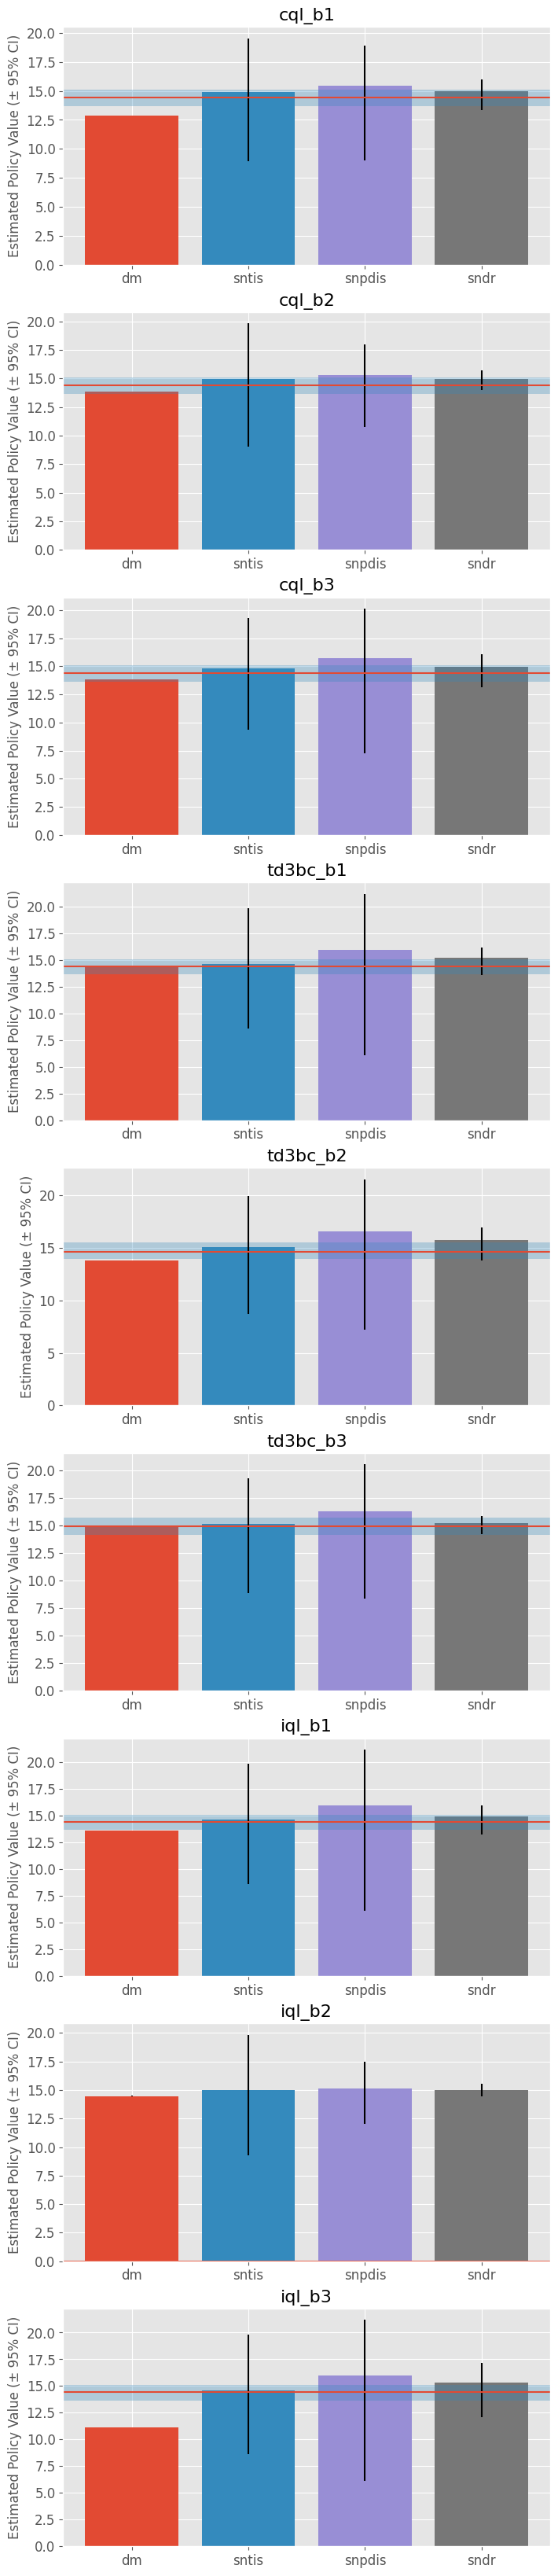

In [65]:
# opeの結果の比較・可視化
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=["dm", "sntis", "snpdis", "sndr"],
    random_state=random_state, 
    sharey=False,
)
# データ収集方策に対する相対方策価値
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, sharey=False)

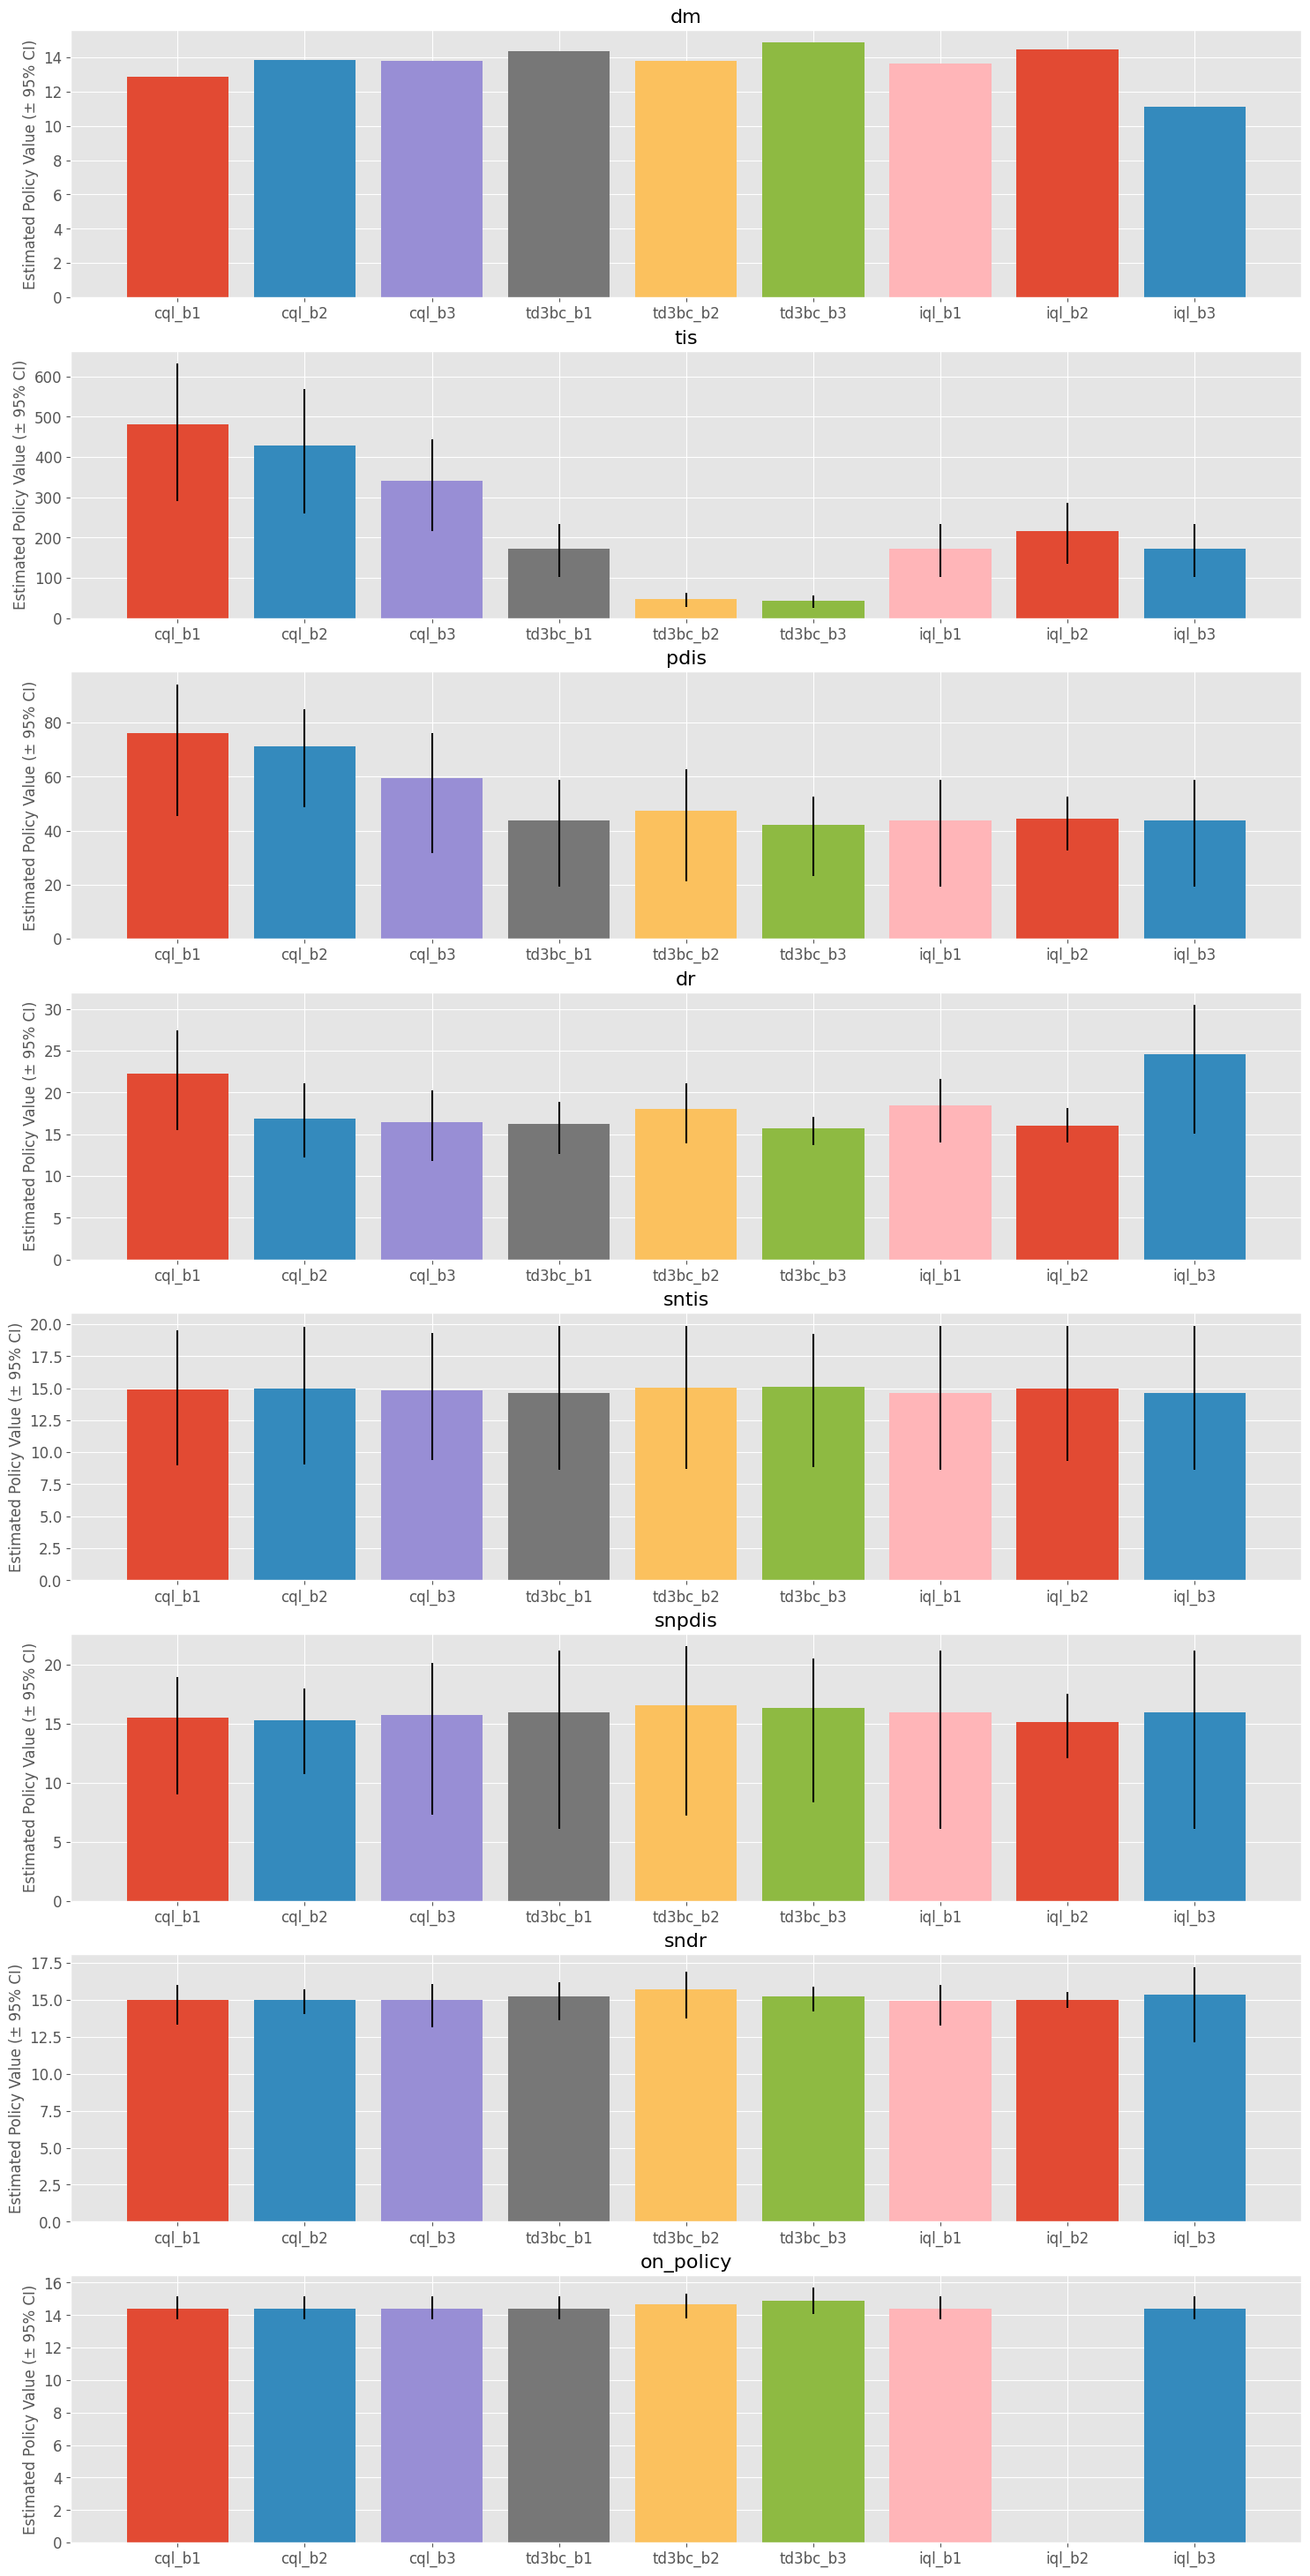

In [66]:
# OPE推定量の候補の方策価値を比較します
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, hue="policy", sharey=False)
# データ収集方策に対する相対方策価値
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, hue="policy", sharey=False)

#### 累積分布関数推定
次に，軌跡単位での報酬の累積分布関数に基づき，方策性能に関する様々な統計量を推定します．

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

特に，上記の累積度数分布から，以下の性能指標を推定することができます．
- 累積分布関数
- 期待値 (方策価値)
- 分散
- CVaR (Conditional Value at Risk)
- 四分位範囲

In [67]:
from scope_rl.ope import CumulativeDistributionOPE
from scope_rl.ope.continuous import CumulativeDistributionDM as CD_DM
from scope_rl.ope.continuous import CumulativeDistributionTIS as CD_IS
from scope_rl.ope.continuous import CumulativeDistributionTDR as CD_DR
from scope_rl.ope.continuous import CumulativeDistributionSNTIS as CD_SNIS
from scope_rl.ope.continuous import CumulativeDistributionSNTDR as CD_SNDR

In [68]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # 方策が取りうる最小の値
        maximum=env.action_space.high,  # 方策が取りうる最大の値
    ),
    bandwidth=1.0,
)

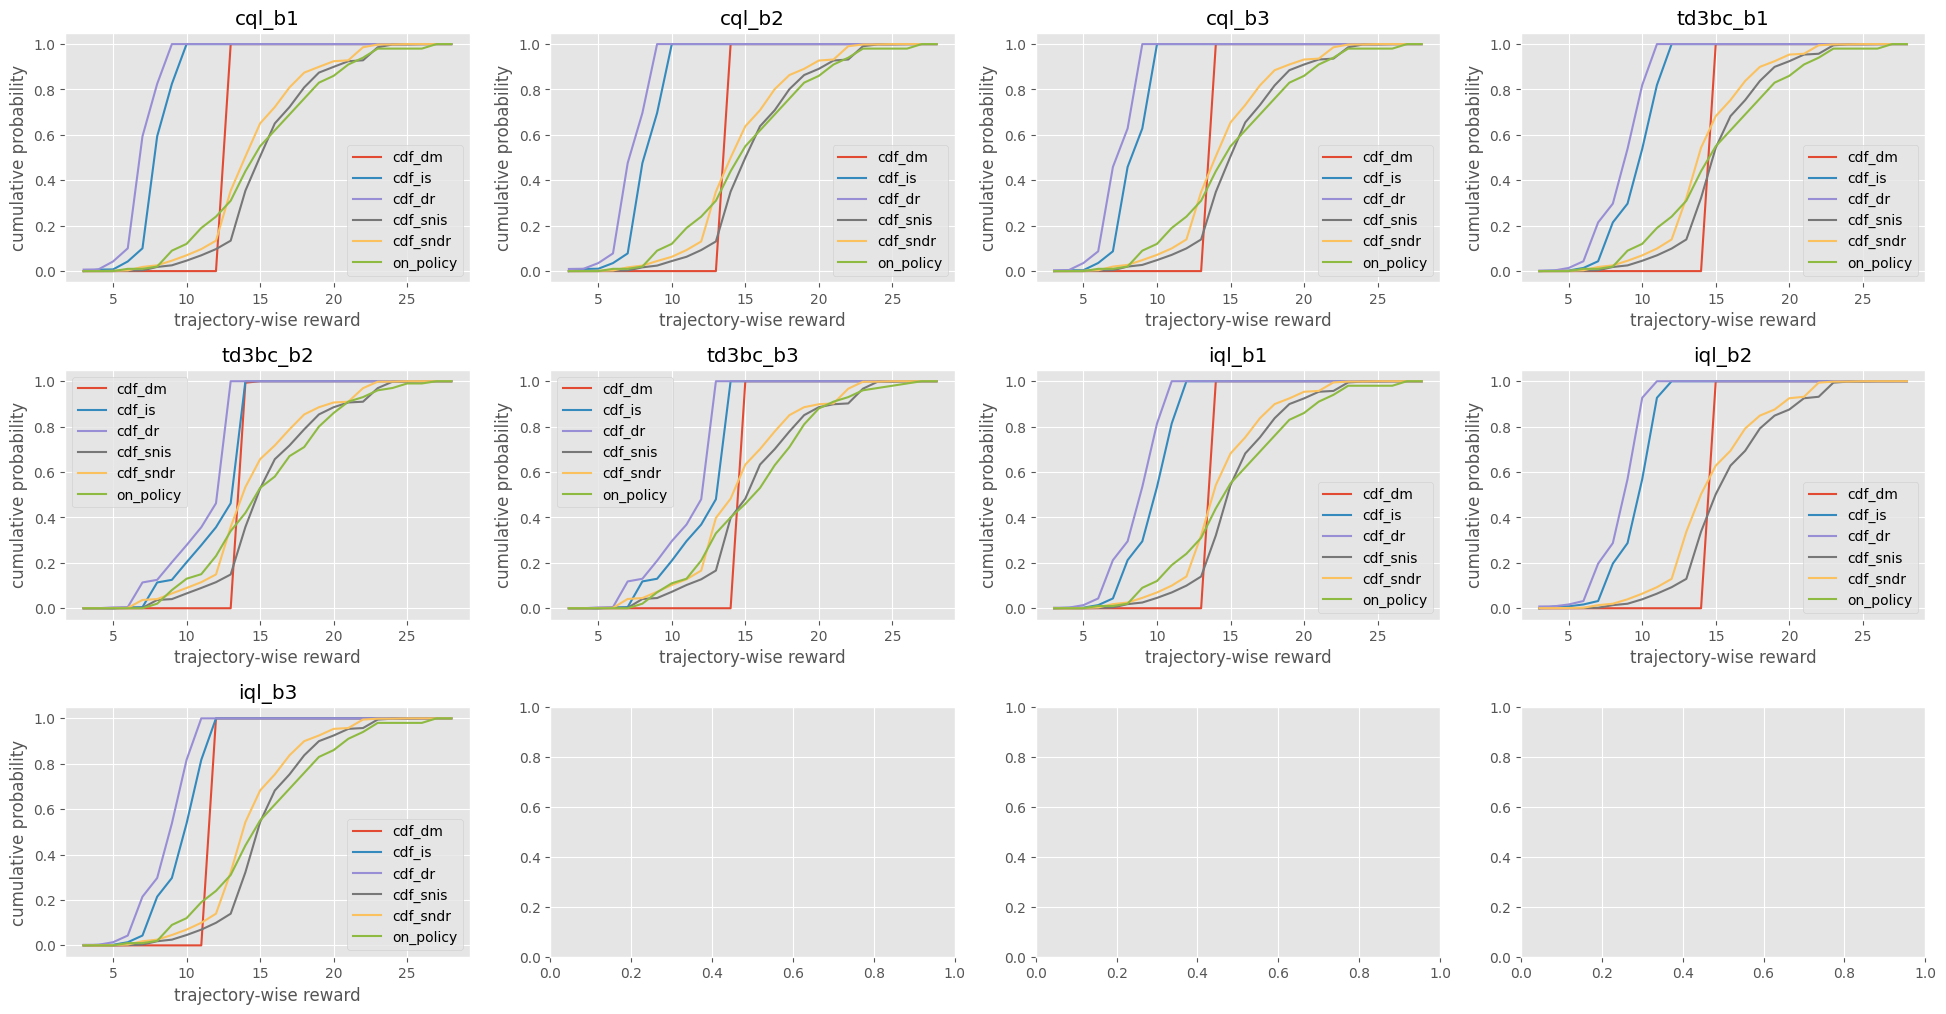

In [69]:
# 累積分布関数
cd_ope.visualize_cumulative_distribution_function(input_dict, n_cols=4)

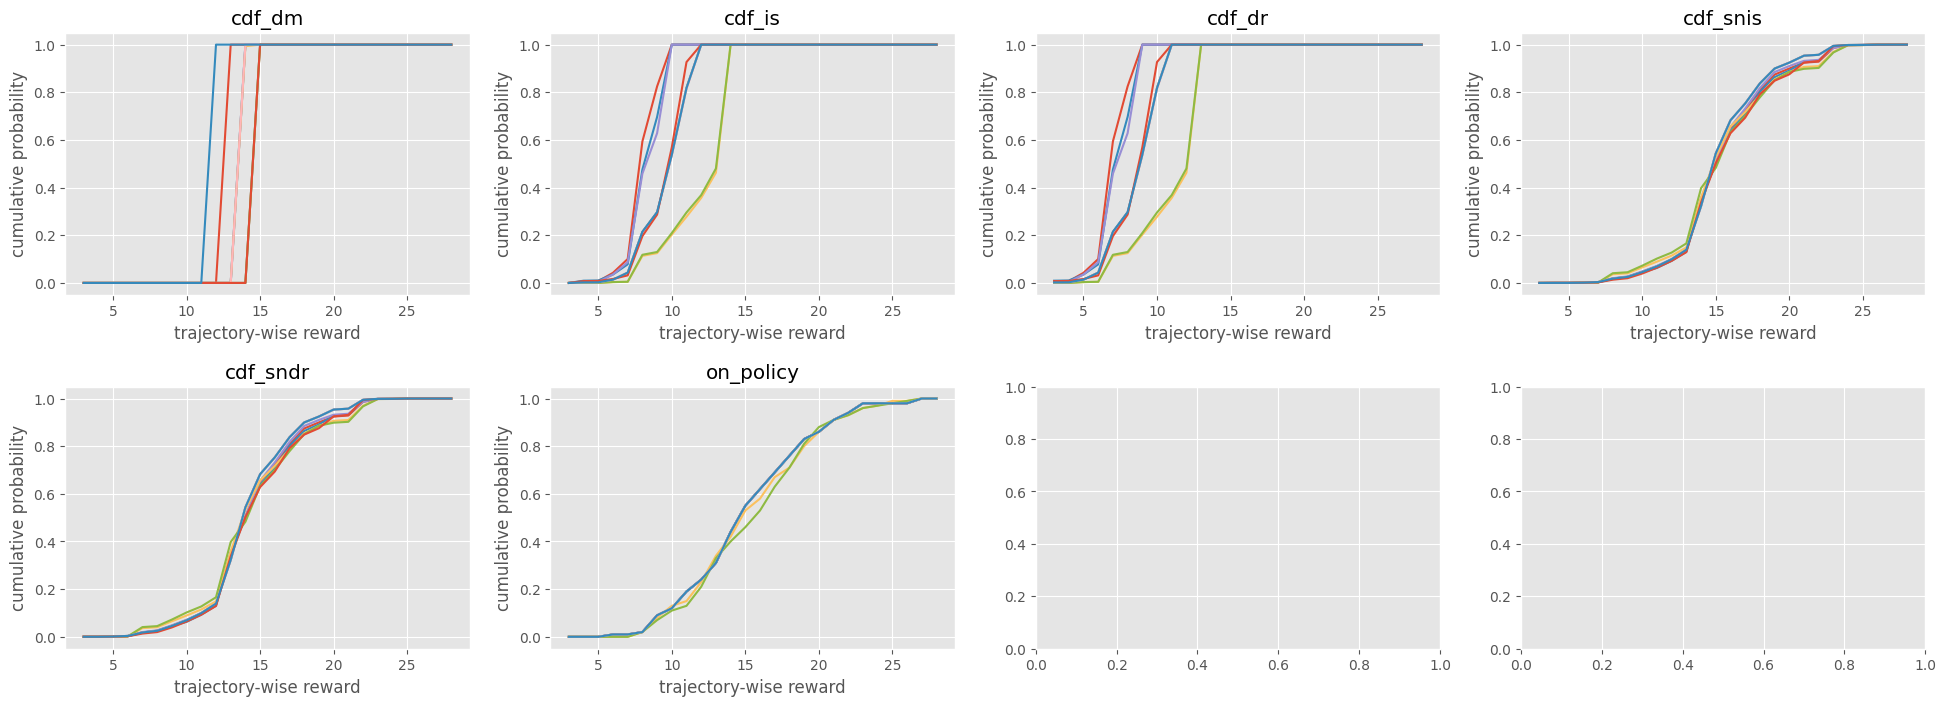

In [70]:
# それぞれのOPE推定量による累積分布関数の比較
# 凡例（評価方策の名前）は省略
cd_ope.visualize_cumulative_distribution_function(
    input_dict, 
    hue="policy",
    n_cols=4,
    legend=False,
)

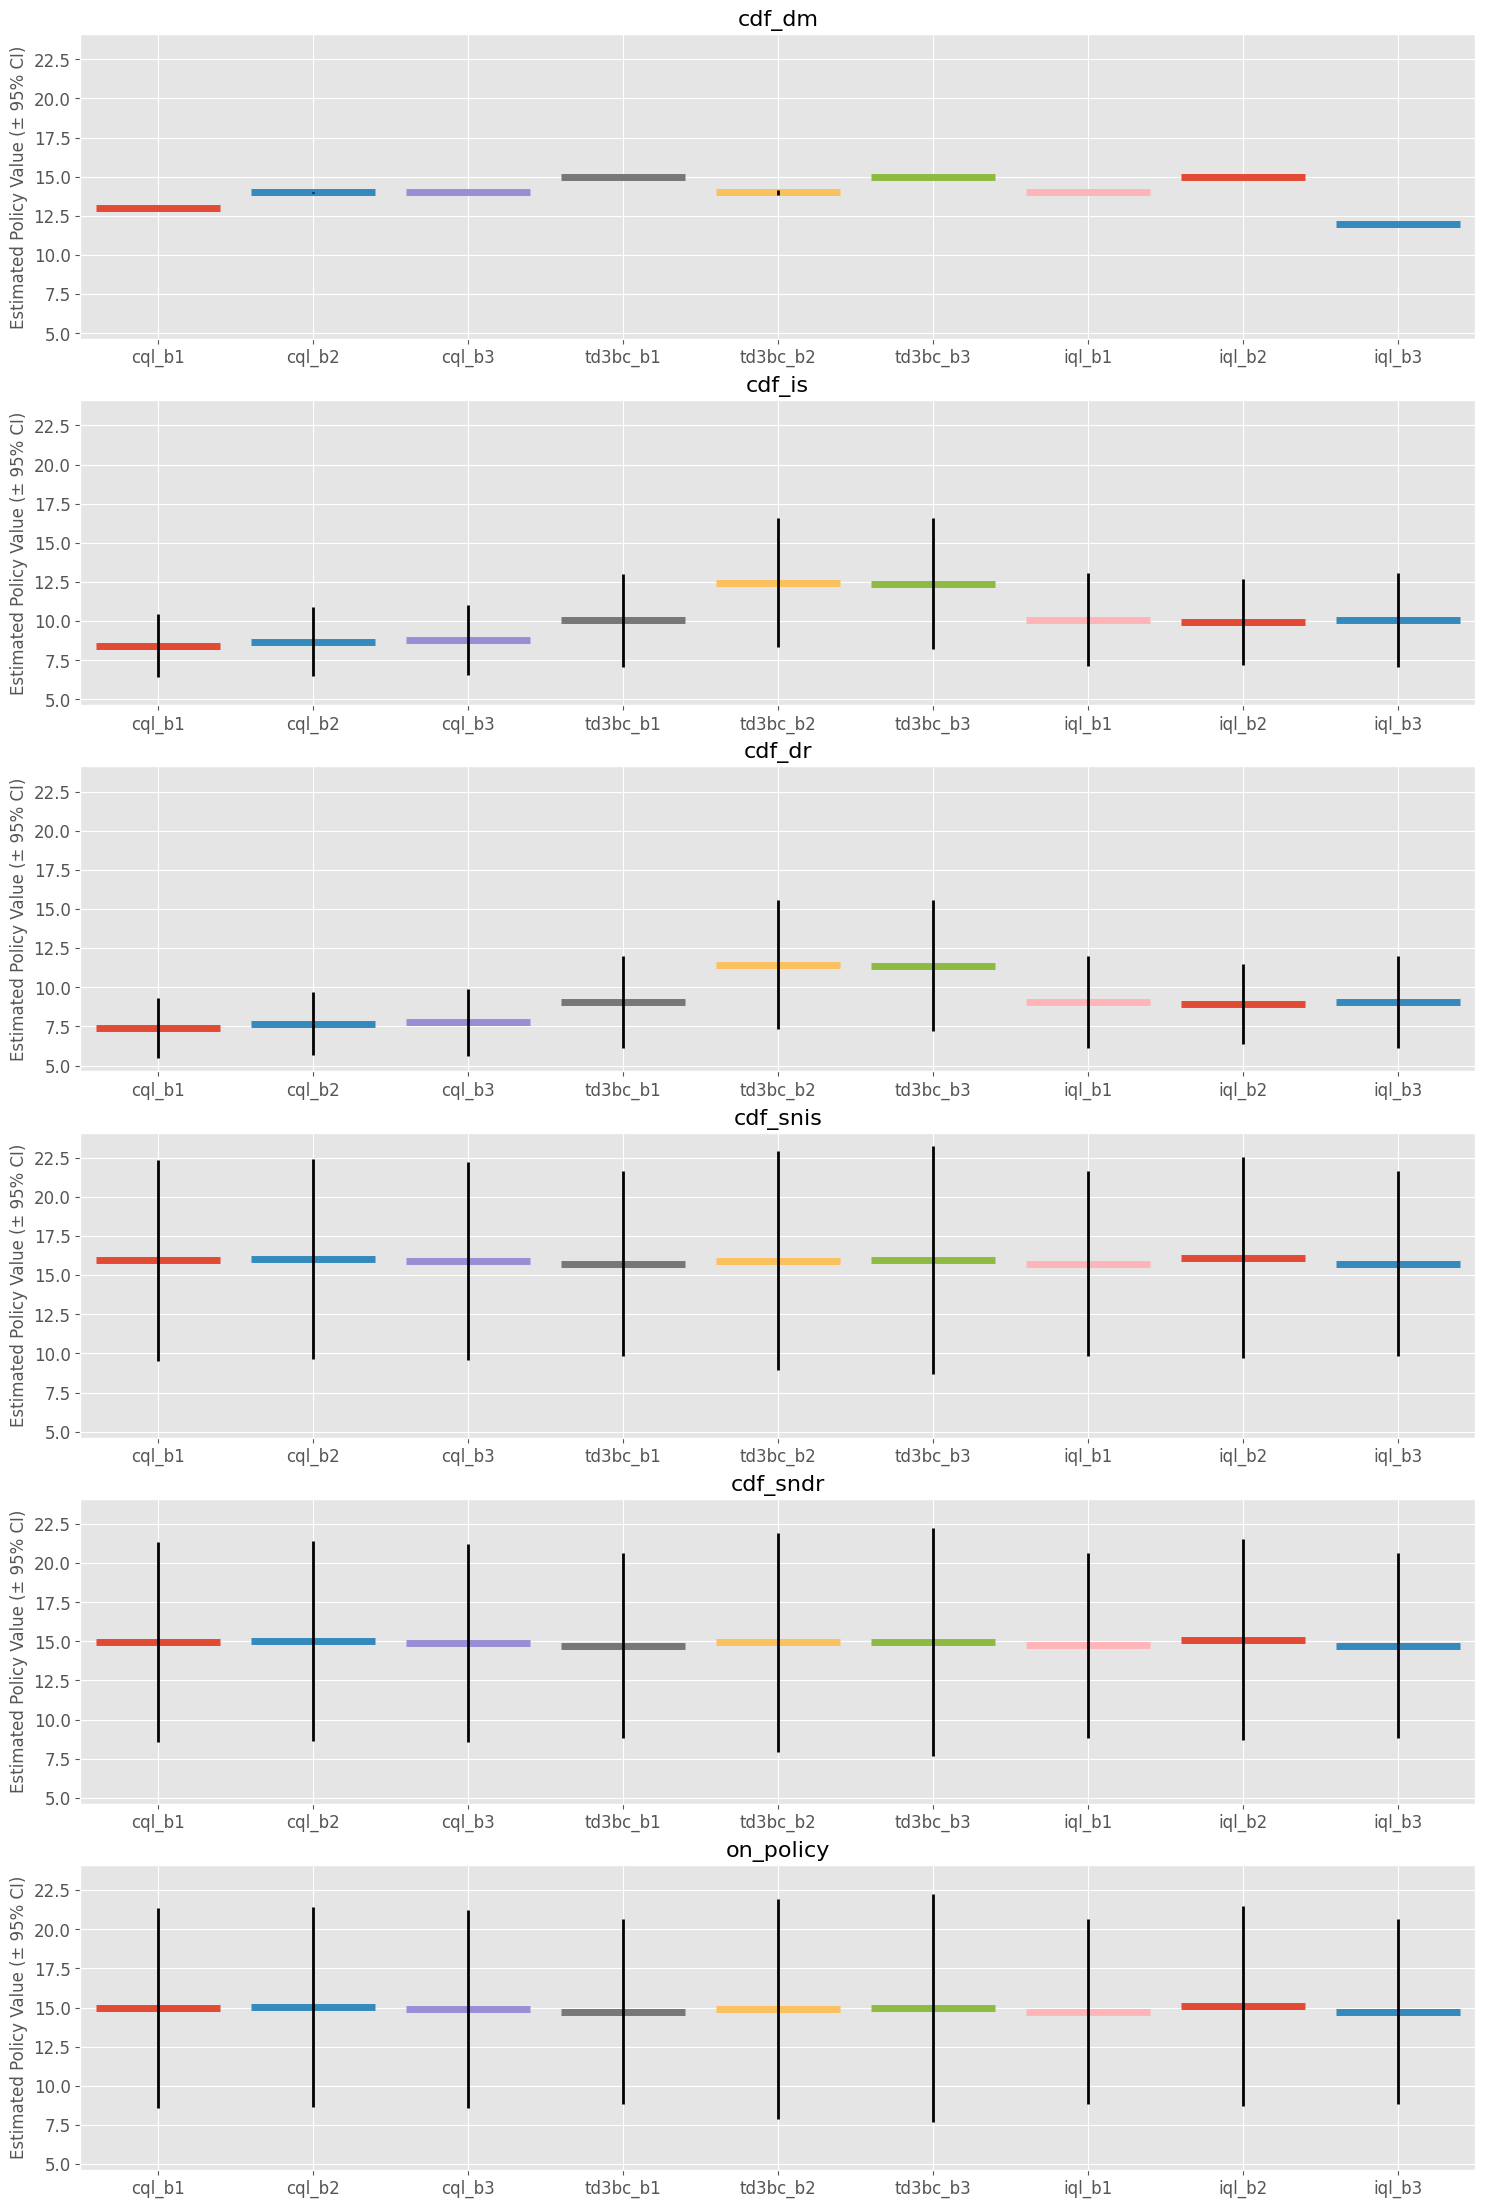

In [71]:
# 累積分布関数から求めた方策価値
mean_dict = cd_ope.estimate_mean(input_dict)
variance_dict = cd_ope.estimate_variance(input_dict)

# OPE推定量による候補方策間での比較
cd_ope.visualize_policy_value(input_dict, hue="policy", sharey=True)

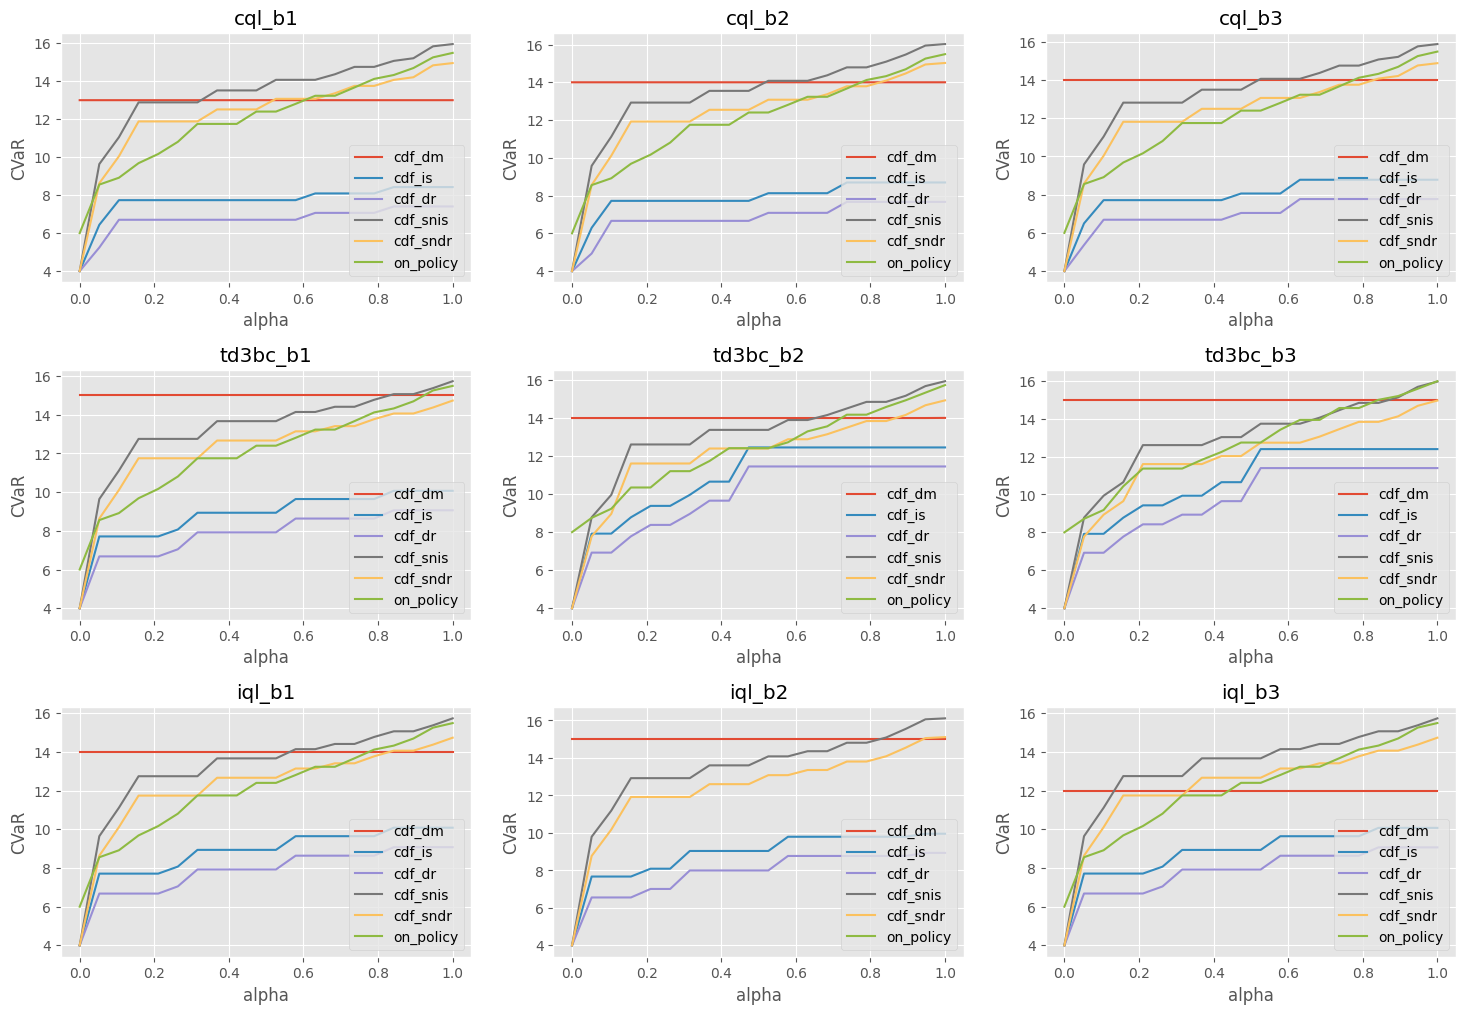

In [72]:
# conditional value at risk
cvar_dict = cd_ope.estimate_conditional_value_at_risk(input_dict, alphas=0.3)
# conditional value at riskの可視化
cd_ope.visualize_conditional_value_at_risk(input_dict, alphas=np.linspace(0, 1, 20), n_cols=3, sharey=True)


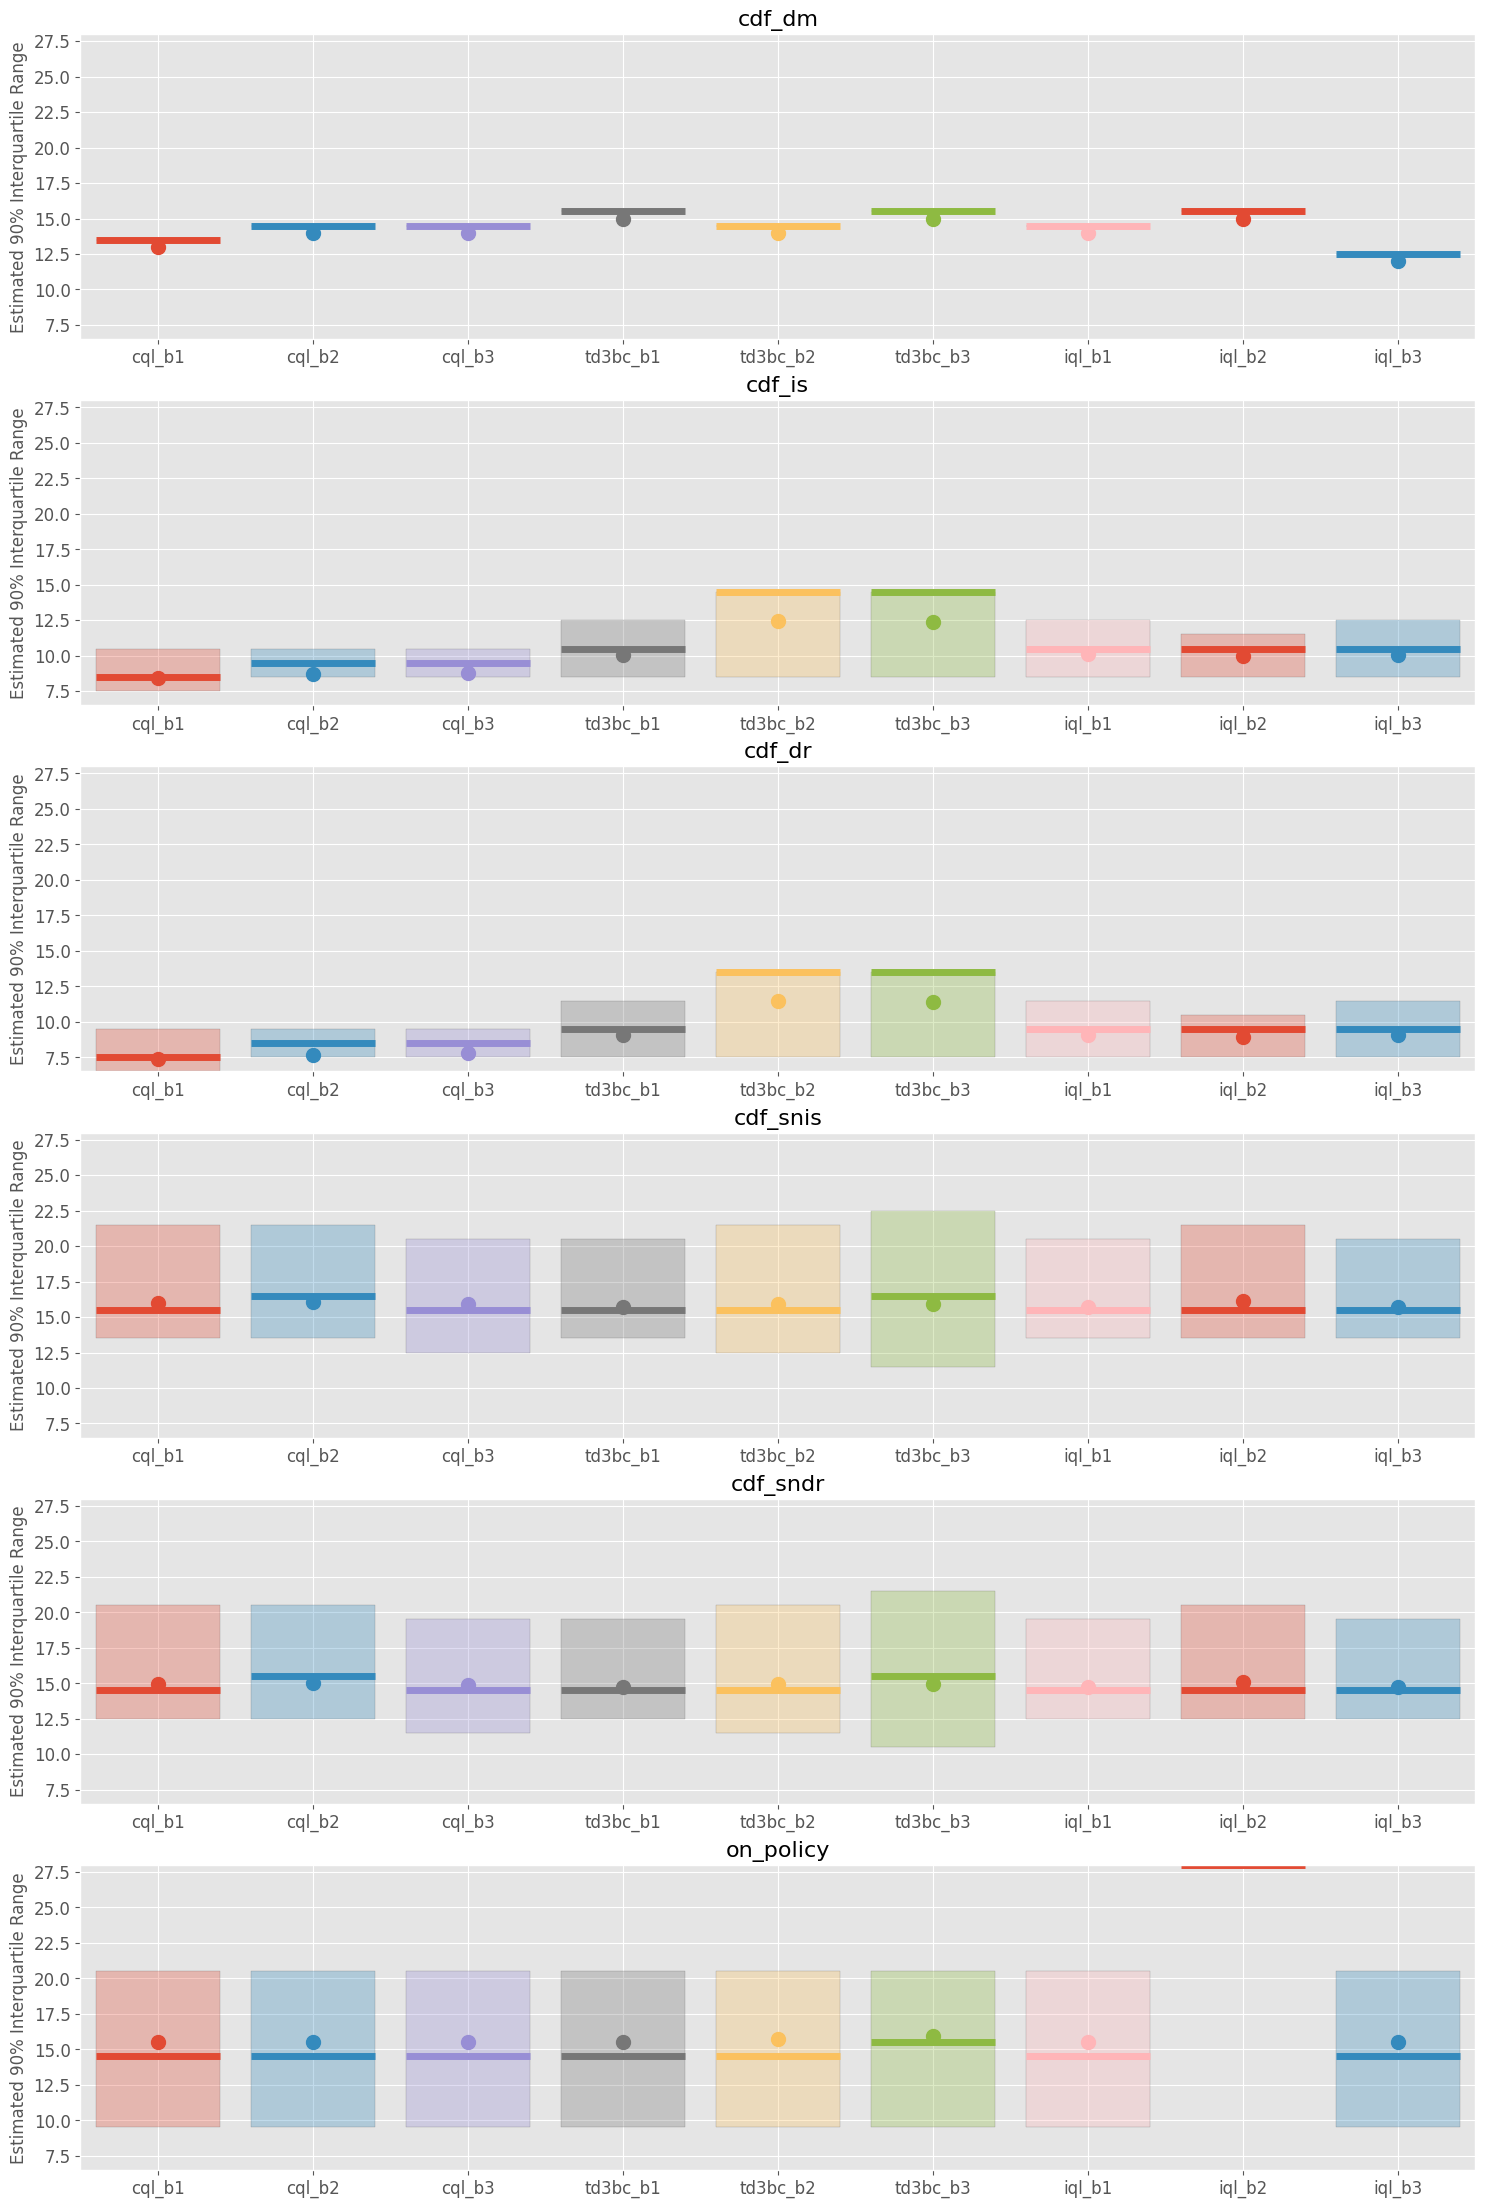

In [73]:
# 四分位範囲
interquartile_range_dict = cd_ope.estimate_interquartile_range(input_dict, alpha=0.10)
# 四分位範囲の可視化
# cd_ope.visualize_interquartile_range(input_dict, alpha=0.10, sharey=True)
# OPE推定量による候補方策間での比較
cd_ope.visualize_interquartile_range(input_dict, alpha=0.10, hue="policy", sharey=True)

## 3. オフ方策選択

オフ方策選択の目的は，これまで推定してきた方策の性能指標に基づき，いくつかの候補方策の中から最も性能の良い方策を選択することです．これは，実際にどの方策を実環境にデプロイするか決定する手順に相当します．

In [74]:
from scope_rl.ope import OffPolicySelection

In [75]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [76]:
ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)

,ranking,policy_value,relative_policy_value,variance,ranking_by_lower_quartile,lower_quartile,ranking_by_conditional_value_at_risk,conditional_value_at_risk
0,td3bc_b3,14.97,1.041167,17.584949,cql_b1,8.0,td3bc_b3,7.6
1,td3bc_b2,14.73,1.024475,18.259697,cql_b2,8.0,td3bc_b2,7.6
2,iql_b3,14.49,1.007783,18.050404,iql_b2,8.0,iql_b3,7.2
3,iql_b1,14.49,1.007783,18.050404,iql_b1,8.0,iql_b1,7.2
4,td3bc_b1,14.49,1.007783,18.050404,td3bc_b3,8.0,td3bc_b1,7.2
5,cql_b3,14.49,1.007783,18.050404,td3bc_b2,8.0,cql_b3,7.2
6,cql_b2,14.49,1.007783,18.050404,td3bc_b1,8.0,cql_b2,7.2
7,cql_b1,14.49,1.007783,18.050404,cql_b3,8.0,cql_b1,7.2
8,iql_b2,0.00,0.000000,0.000000,iql_b3,0.0,iql_b2,0.0


In [77]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [78]:
ranking_df

{'dm':   estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0          td3bc_b3               14.857771                         1.033361   
 1            iql_b2               14.480394                         1.007115   
 2          td3bc_b1               14.376833                         0.999912   
 3            cql_b2               13.872906                         0.964864   
 4          td3bc_b2               13.801890                         0.959924   
 5            cql_b3               13.800434                         0.959823   
 6            iql_b1               13.621825                         0.947401   
 7            cql_b1               12.886773                         0.896278   
 8            iql_b3               11.116166                         0.773132   
 
    true_ranking  true_policy_value  true_relative_policy_value  
 0             0              14.97                    1.041167  
 1             8               0.00               

In [79]:
metric_df

,estimator,mean_squared_error,rank_correlation,pvalue,regret@1,type_i_error_rate,type_ii_error_rate
0,dm,25.125748,0.033333,0.932157,0.00,0.0,0.0
1,tis,69671.247471,-0.883333,0.001591,0.48,0.0,0.0
2,pdis,1696.974683,-0.633333,0.067086,0.48,0.0,0.0
3,dr,51.230600,0.016667,0.966055,0.48,0.0,0.0
4,sntis,25.475659,-0.516667,0.154390,14.97,0.0,0.0
5,snpdis,26.830811,0.950000,0.000088,0.24,0.0,0.0
6,sndr,25.278154,0.483333,0.187470,0.24,0.0,0.0


In [80]:
ranking_df, metric_df = ops.select_by_policy_value_via_cumulative_distribution_ope(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [81]:
metric_df

,estimator,mean_squared_error,rank_correlation,pvalue,regret@1,type_i_error_rate,type_ii_error_rate
0,cdf_dm,26.102712,-0.083333,0.831214,14.97,0.0,0.0
1,cdf_is,30.268738,0.866667,0.002495,0.24,0.0,0.0
2,cdf_dr,37.053179,0.866667,0.002495,0.24,0.0,0.0
3,cdf_snis,30.347416,-0.516667,0.154390,14.97,0.0,0.0
4,cdf_sndr,25.469741,-0.516667,0.154390,14.97,0.0,0.0


In [82]:
ranking_df, metric_df = ops.select_by_policy_value_lower_bound(
    input_dict=input_dict,
    cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    return_metrics=True,
    return_by_dataframe=True,
    random_state=12345,
)

In [83]:
metric_df

,ci,estimator,mean_squared_error,rank_correlation,pvalue,regret@1,type_i_error_rate,type_ii_error_rate
0,bootstrap,dm,NaN,0.033333,0.932157,0.00,0.000000,0.0
1,bootstrap,tis,NaN,-0.866667,0.002495,0.48,0.000000,0.0
2,bootstrap,pdis,NaN,-0.600000,0.087623,0.48,0.000000,0.0
3,bootstrap,dr,NaN,0.316667,0.406397,0.48,0.000000,0.0
4,bootstrap,sntis,NaN,0.066667,0.864690,0.00,0.000000,0.0
5,bootstrap,snpdis,NaN,-0.400000,0.286105,14.97,0.000000,0.0
6,bootstrap,sndr,NaN,0.216667,0.575515,0.00,0.000000,0.0
7,bernstein,dm,NaN,0.033333,0.932157,0.00,0.000000,0.0
8,bernstein,tis,NaN,0.633333,0.067086,0.24,1.000000,0.0
9,bernstein,pdis,NaN,-0.733333,0.024554,14.97,1.000000,0.0


In [84]:
ranking_df, metric_df = ops.select_by_lower_quartile(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [85]:
metric_df

,estimator,mean_squared_error,rank_correlation,pvalue,regret,type_i_error_rate,type_ii_error_rate
0,cdf_dm,58.250000,-0.166667,0.668231,NaN,0.0,0.0
1,cdf_is,8.250000,-0.750000,0.019942,NaN,0.0,0.0
2,cdf_dr,7.138889,-0.750000,0.019942,NaN,0.0,0.0
3,cdf_snis,24.250000,-0.600000,0.087623,NaN,0.0,0.0
4,cdf_sndr,16.916667,-0.600000,0.087623,NaN,0.0,0.0


In [86]:
ranking_df, metric_df = ops.select_by_conditional_value_at_risk(
    input_dict=input_dict,
    return_metrics=True,
    return_by_dataframe=True,
)

In [87]:
metric_df

,estimator,mean_squared_error,rank_correlation,pvalue,regret,type_i_error_rate,type_ii_error_rate
0,cdf_dm,64.106667,-0.266667,0.487922,NaN,0.0,0.0
1,cdf_is,6.861961,0.866667,0.002495,NaN,0.0,0.0
2,cdf_dr,6.339950,0.866667,0.002495,NaN,0.0,0.0
3,cdf_snis,14.876467,-0.516667,0.154390,NaN,0.0,0.0
4,cdf_sndr,9.883098,-0.516667,0.154390,NaN,0.0,0.0


In [88]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
)

In [89]:
topk_metric_df[:30]

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,dm,0,14.97,14.97,14.97,14.970000,NaN,0.000000,NaN
1,dm,1,0.00,14.97,0.00,7.485000,10.585389,0.500000,0.055917
2,dm,2,14.49,14.97,0.00,9.820000,8.507755,0.333333,0.069572
3,dm,3,14.49,14.97,0.00,10.987500,7.328494,0.250000,0.080767
4,dm,4,14.73,14.97,0.00,11.736000,6.563641,0.200000,0.090179
5,dm,5,14.49,14.97,0.00,12.195000,5.977390,0.166667,0.099023
6,dm,6,14.49,14.97,0.00,12.522857,5.525102,0.142857,0.107129
7,dm,7,14.49,14.97,0.00,12.768750,5.162315,0.125000,0.114658
8,dm,8,14.49,14.97,0.00,12.960000,4.862870,0.111111,0.121718
0,tis,0,14.49,14.49,14.49,14.490000,NaN,0.000000,NaN


In [90]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
)

In [91]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,cdf_dm,0,0.00,0.00,0.0,0.0000,NaN,1.000000,NaN
1,cdf_dm,1,14.97,14.97,0.0,7.4850,10.585389,0.500000,0.055917
2,cdf_dm,2,14.49,14.97,0.0,9.8200,8.507755,0.333333,0.069572
3,cdf_dm,3,14.73,14.97,0.0,11.0475,7.367606,0.250000,0.080338
4,cdf_dm,4,14.49,14.97,0.0,11.7360,6.563641,0.200000,0.090179


In [92]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    relative_safety_criteria=1.0,
    return_by_dataframe=True,
    random_state=random_state,
)

In [93]:
topk_metric_df.head()

,ci,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,bootstrap,dm,0,14.49,14.49,14.49,14.490,NaN,0.0,NaN
1,bootstrap,dm,1,14.49,14.49,14.49,14.490,0.000000,0.0,inf
2,bootstrap,dm,2,14.49,14.49,14.49,14.490,0.000000,0.0,inf
3,bootstrap,dm,3,14.73,14.73,14.49,14.550,0.120000,0.0,2.932500
4,bootstrap,dm,4,14.49,14.73,14.49,14.538,0.107331,0.0,3.278635


In [94]:
topk_metric_df = ops.obtain_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=7.0,
    return_by_dataframe=True,
)

In [95]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,dm,0,8.1,8.1,8.1,8.100000,NaN,0.000000,NaN
1,dm,1,0.0,8.1,0.0,4.050000,5.727565,0.500000,0.0
2,dm,2,7.7,8.1,0.0,5.266667,4.565450,0.333333,0.0
3,dm,3,7.7,8.1,0.0,5.875000,3.921203,0.250000,0.0
4,dm,4,8.0,8.1,0.0,6.300000,3.526330,0.200000,0.0


In [96]:
topk_metric_df = ops.obtain_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=7.0,
    return_by_dataframe=True,
)

In [97]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,cdf_dm,0,0.0,0.0,0.0,0.000000,NaN,1.000000,NaN
1,cdf_dm,1,8.1,8.1,0.0,4.050000,5.727565,0.500000,0.0
2,cdf_dm,2,7.7,8.1,0.0,5.266667,4.565450,0.333333,0.0
3,cdf_dm,3,7.7,8.1,0.0,5.875000,3.921203,0.250000,0.0
4,cdf_dm,4,8.0,8.1,0.0,6.300000,3.526330,0.200000,0.0


In [98]:
topk_metric_df = ops.obtain_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=10.0,
    return_by_dataframe=True,
)

In [99]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,dm,0,9.0,9.0,9.0,9.0,NaN,1.0,NaN
1,dm,1,9.0,9.0,9.0,9.0,0.0,1.0,NaN
2,dm,2,9.0,9.0,9.0,9.0,0.0,1.0,NaN
3,dm,3,9.0,9.0,9.0,9.0,0.0,1.0,NaN
4,dm,4,9.0,9.0,9.0,9.0,0.0,1.0,NaN


In [100]:
topk_metric_df = ops.obtain_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.1,
    return_safety_violation_rate=True,
    safety_threshold=10.0,
    return_by_dataframe=True,
)

In [101]:
topk_metric_df.head()

,estimator,topk,k-th,best,worst,mean,std,safety_violation_rate,sharpe_ratio
0,cdf_dm,0,9.0,9.0,9.0,9.0,NaN,1.0,NaN
1,cdf_dm,1,9.0,9.0,9.0,9.0,0.0,1.0,NaN
2,cdf_dm,2,9.0,9.0,9.0,9.0,0.0,1.0,NaN
3,cdf_dm,3,9.0,9.0,9.0,9.0,0.0,1.0,NaN
4,cdf_dm,4,9.0,9.0,9.0,9.0,0.0,1.0,NaN


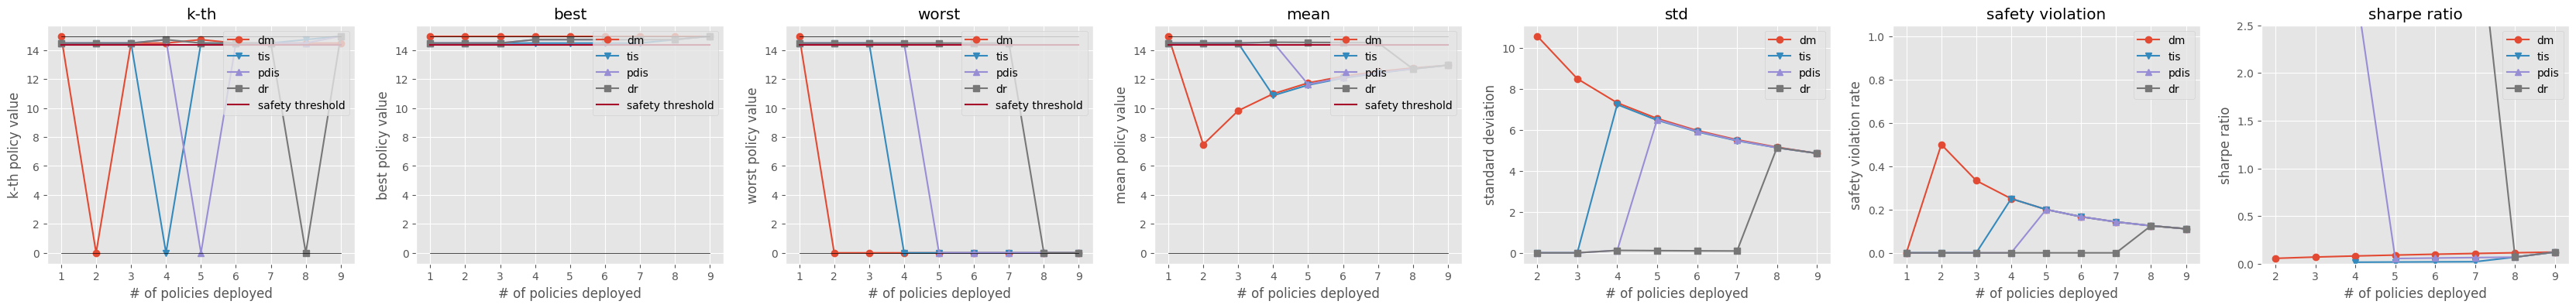

In [102]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    relative_safety_criteria=1.0,
    ymax_sharpe_ratio=2.5,
    legend=True,
)

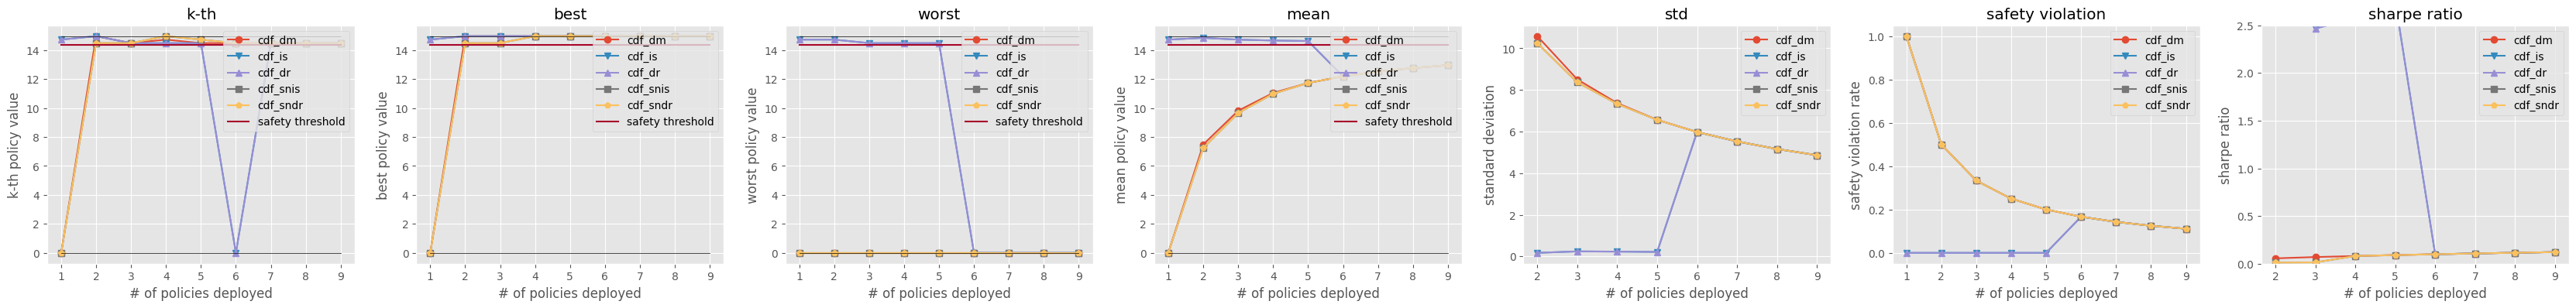

In [103]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    relative_safety_criteria=1.0,
    ymax_sharpe_ratio=2.5,
    legend=True,
)

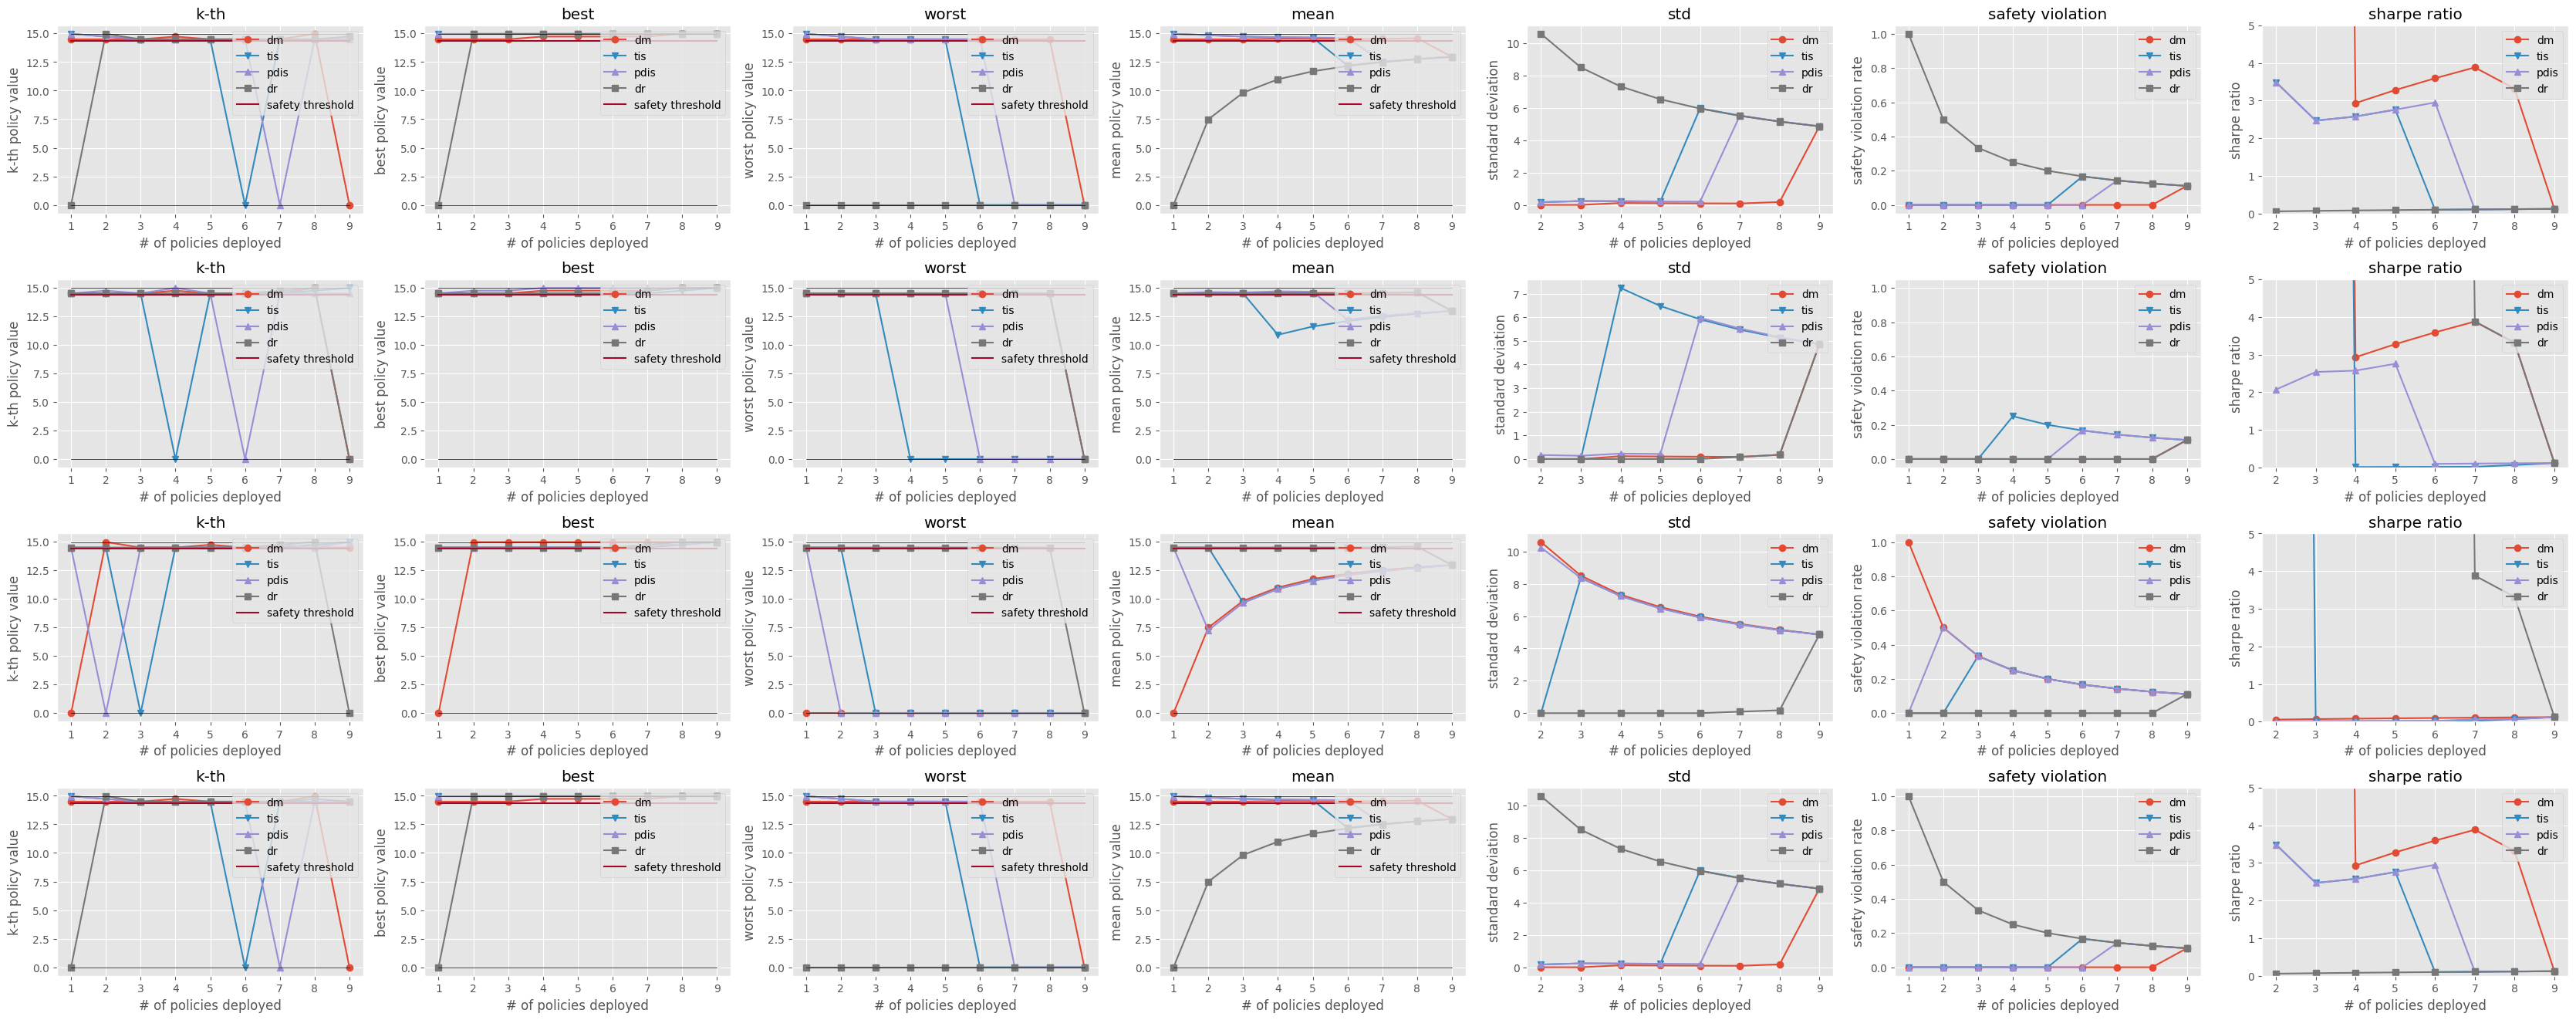

In [104]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    relative_safety_criteria=1.0,
    clip_sharpe_ratio=True,
    ymax_sharpe_ratio=5.0,
    legend=True,
    random_state=12345,
)

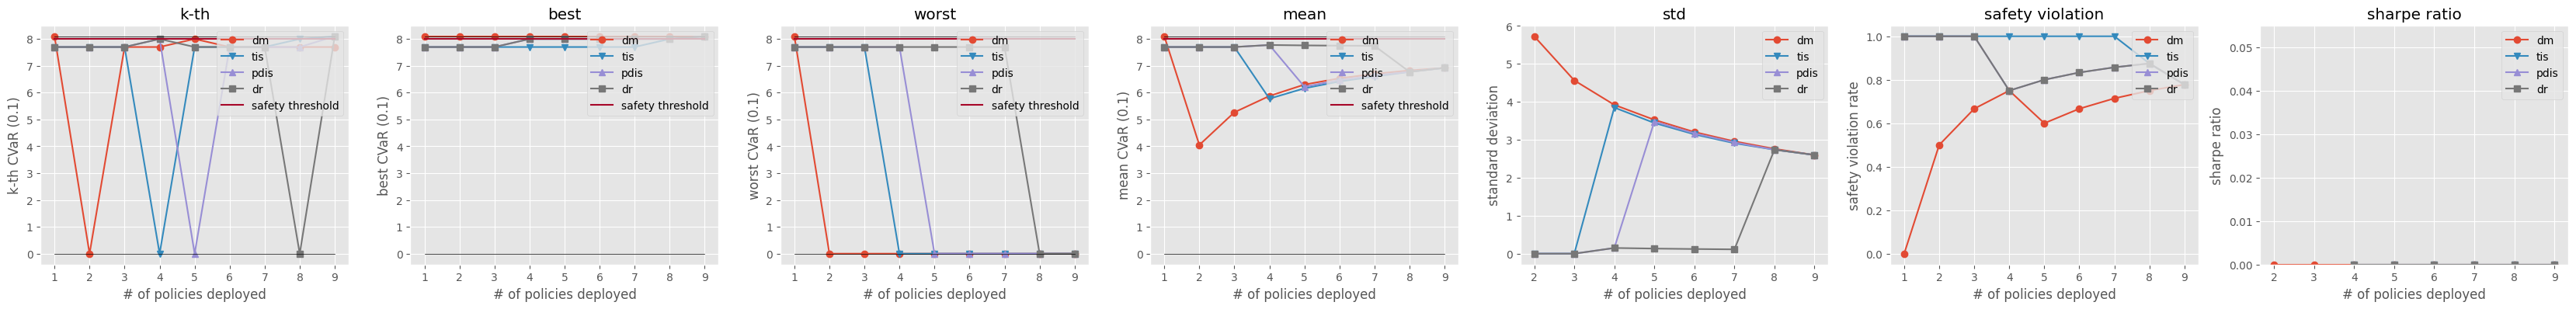

In [105]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
)

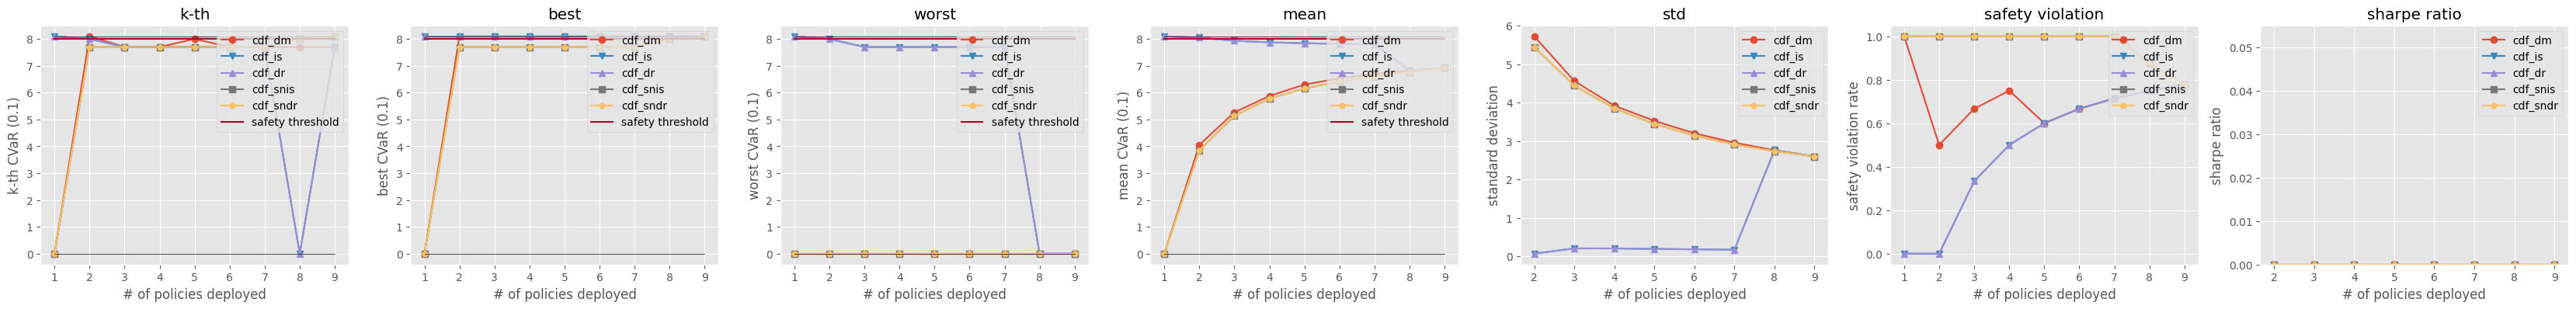

In [106]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
)

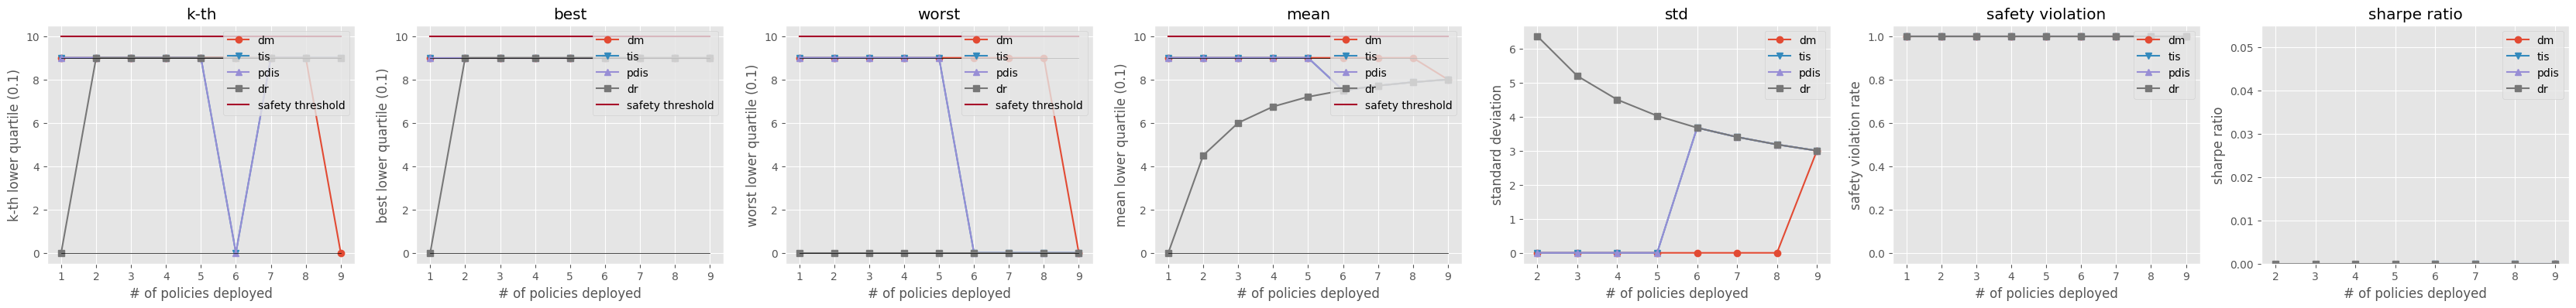

In [107]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_alpha=0.10,
    safety_threshold=10.0,
    legend=True,
)

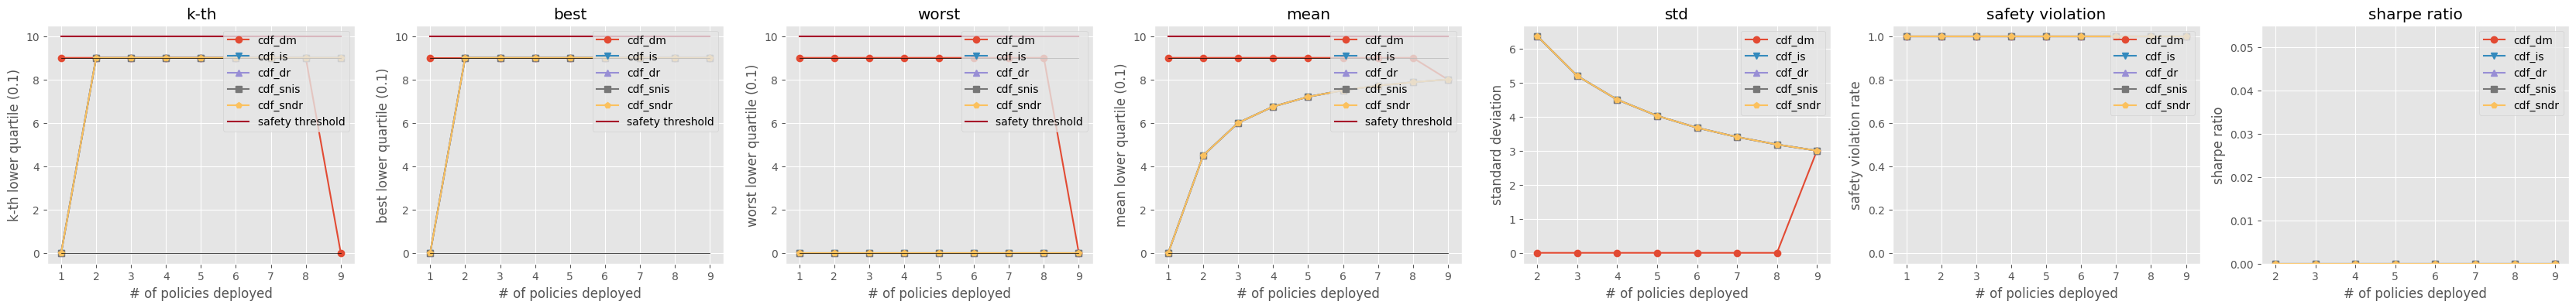

In [108]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    ope_alpha=0.10,
    safety_threshold=10.0,
    legend=True,
)

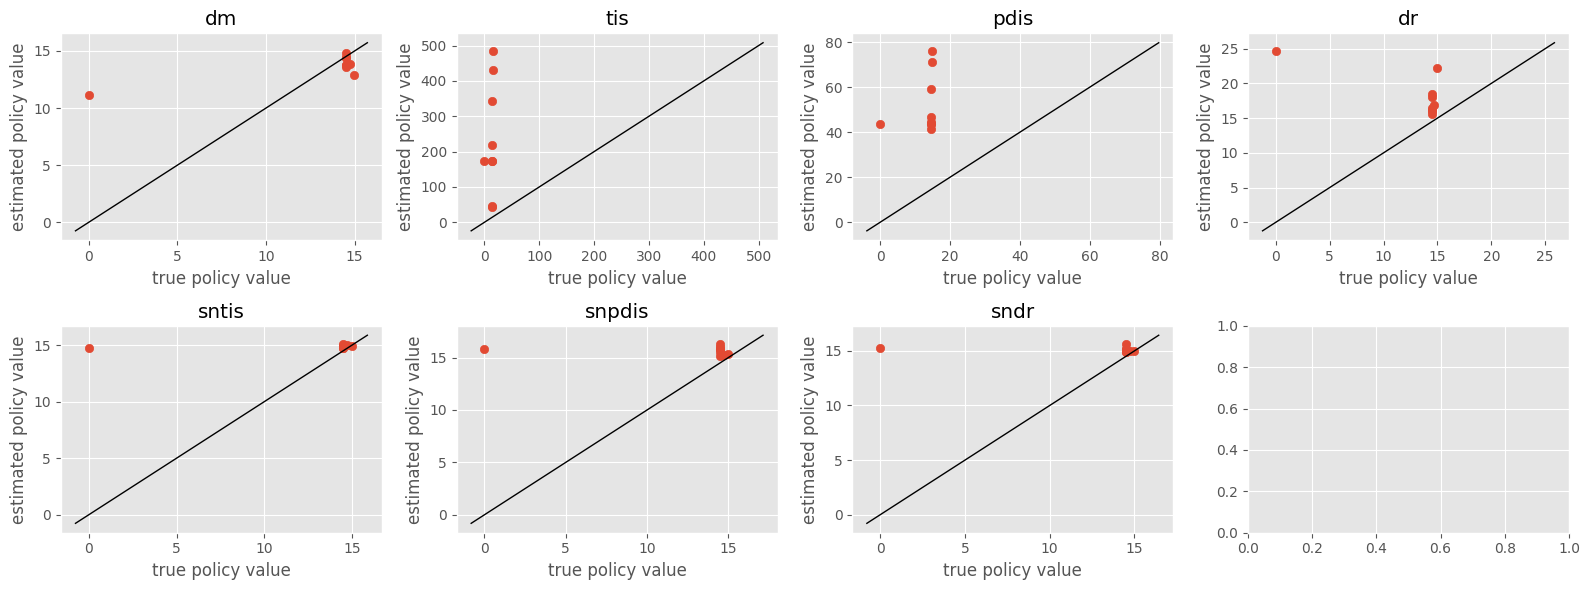

In [109]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
)

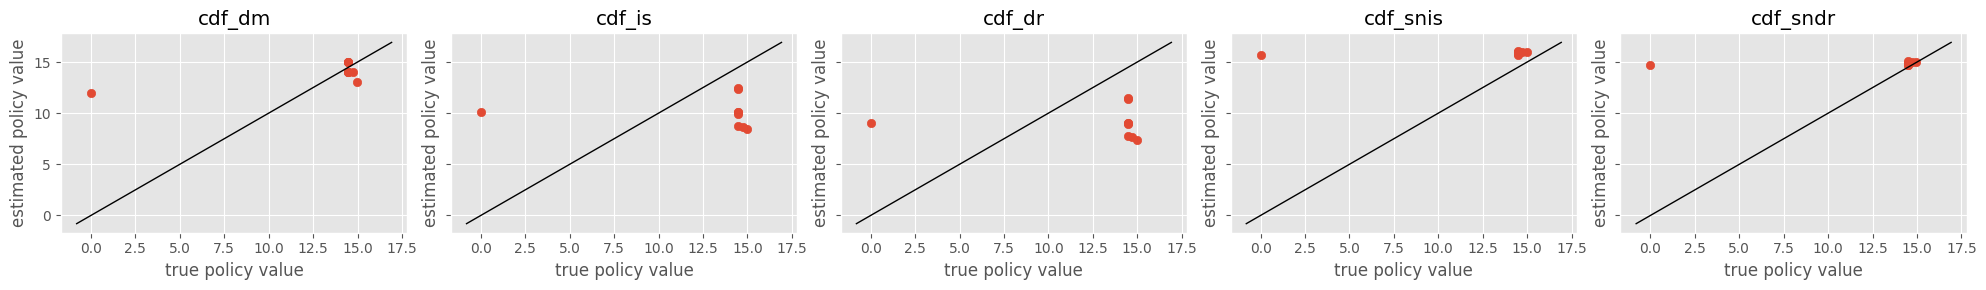

In [110]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

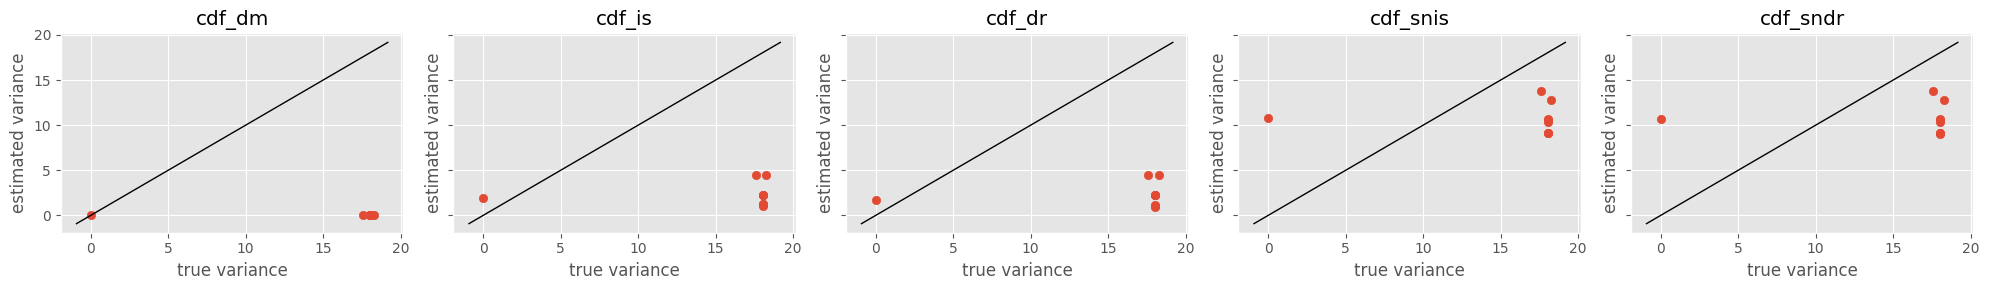

In [111]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

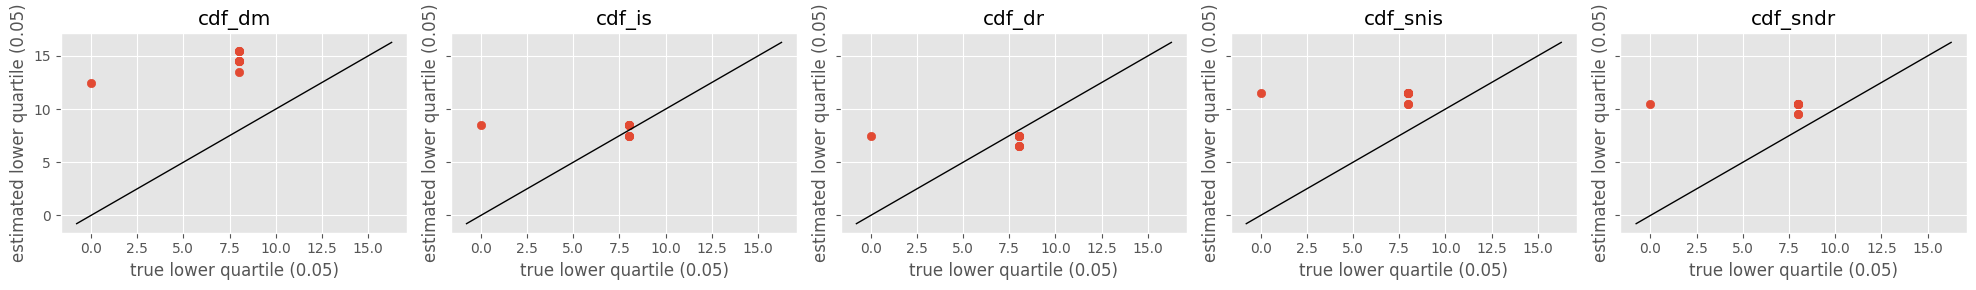

In [112]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

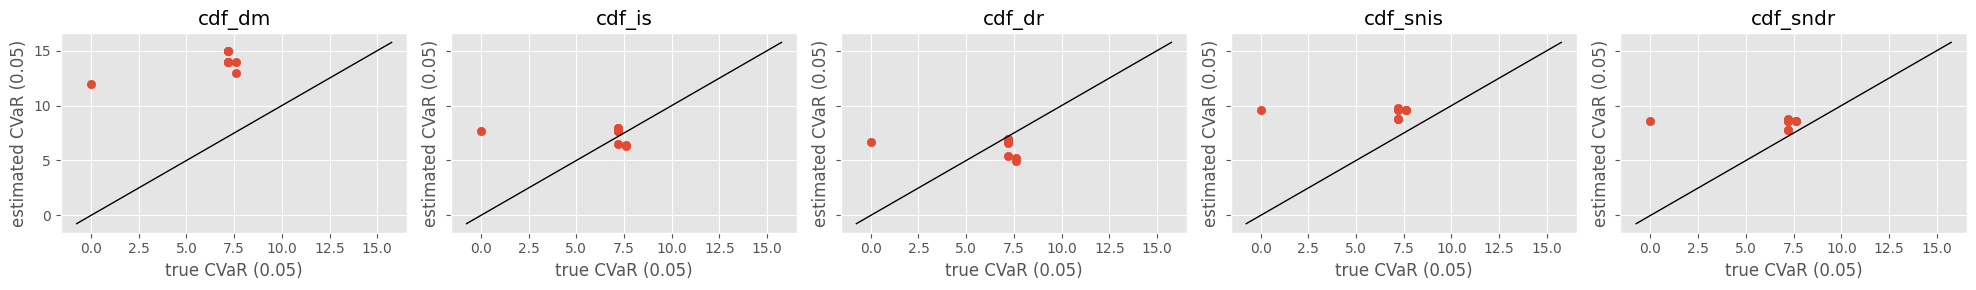

In [113]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

複数のデータセットでOPE/OPSを行う方法は，以下を参照してください．[examples/quickstart_ja/rtb/rtb_synthetic_continuous_multiple_datasets_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_continuous_multiple_datasets_ja.ipynb).

離散的な行動空間に対する例は，以下を参照してください． [examples/quickstart_ja/rtb/rtb_synthetic_discrete_advanced_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_discrete_advanced_ja.ipynb).

## 参考文献

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Haanvid Lee, Jongmin Lee, Yunseon Choi, Wonseok Jeon, Byung-Jun Lee, Yung-Kyun Noh, and Kee-Eung Kim. \
"Local Metric Learning for Off-Policy Evaluation in Contextual Bandits with Continuous Actions.", 2022.

- Ilya Kostrikov, Ashvin Nair, and Sergey Levine. \
"Offline Reinforcement Learning with Implicit Q-Learning.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Scott Fujimoto and Shixiang Shane Gu. \
"A Minimalist Approach to Offline Reinforcement Learning.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Angela Zhou. \
"Policy Evaluation and Optimization with Continuous Treatments.", 2019.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.